In [9]:
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,StratifiedKFold
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.metrics import log_loss,f1_score
import seaborn as sns

In [4]:
pd.set_option('display.max_columns', 50) 

In [3]:
train_df = pd.read_csv('./jobcare/train.csv')
test_df = pd.read_csv('./jobcare/test.csv')
sample_df= pd.read_csv('./jobcare/sample_submission.csv')

In [46]:
train_df.name = 'train'
test_df.name = 'test'

# data exploration

In [34]:
#detect Null
print(train_df.info())
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501951 entries, 82335 to 304230
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      501951 non-null  int64         
 1   d_l_match_yn            501951 non-null  int64         
 2   d_m_match_yn            501951 non-null  int64         
 3   d_s_match_yn            501951 non-null  int64         
 4   h_l_match_yn            501951 non-null  int64         
 5   h_m_match_yn            501951 non-null  int64         
 6   h_s_match_yn            501951 non-null  int64         
 7   person_attribute_a      501951 non-null  int64         
 8   person_attribute_a_1    501951 non-null  int64         
 9   person_attribute_b      501951 non-null  int64         
 10  person_prefer_c         501951 non-null  int64         
 11  person_prefer_d_1       501951 non-null  int64         
 12  person_prefer_d_2       50

In [47]:
def detect_values(df_list:list):
    for df in df_list:
        print(df.name +'\n')
        for col in df.columns:
            print(f'{col}: {df[col].unique()}')
detect_values(df_list)
# ['person_attribute_a_1','person_attribute_b','person_prefer_e','contents_attribute_e','person_rn','contents_rn','']

train

d_l_match_yn: [0 1]
d_m_match_yn: [0 1]
d_s_match_yn: [0 1]
h_l_match_yn: [1 0]
h_m_match_yn: [1 0]
h_s_match_yn: [0 1]
person_attribute_a: [2 1]
person_attribute_a_1: [0 7 1 3 5 6 4 2]
person_attribute_b: [2 1 3 4 5 0]
person_prefer_c: [5 1 4 2 3]
person_prefer_d_1: [289 833 112 ... 484 485 559]
person_prefer_d_2: [873 700 113 ...  84 922 193]
person_prefer_d_3: [ 910  840  120 ...  589  491 1044]
person_prefer_e: [ 5  3  4  0  6 10  2  8  7  9 11  1]
person_prefer_h_1: [101 113  59   4 283 138 135  77  31  86 297 254 119 209 258 229 255 109
  88  72   2  20 172 171 133 210  44 279 281  96  27 139 131   7 199  65
  49  93   9  21 214  66  90  54 178 104 251 140  95 114 146 280  68 217
  11 189 263 195  79 116  41 288 213 285  87 300 309 100 141 173 196 190
  74  52  32  43 242 215  63  23  82 184 252  56  39 234 236 127  47 186
 206 106 124 151  16 278 310  40 129  91  67  12  19 128 272 257 152 177
  80 225  34   6  15 256 284 170 105 212  13 107 202  37 231 125 290 126
 291 2

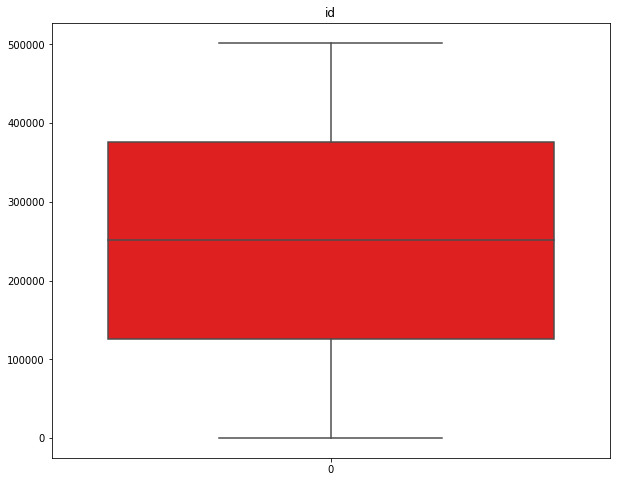

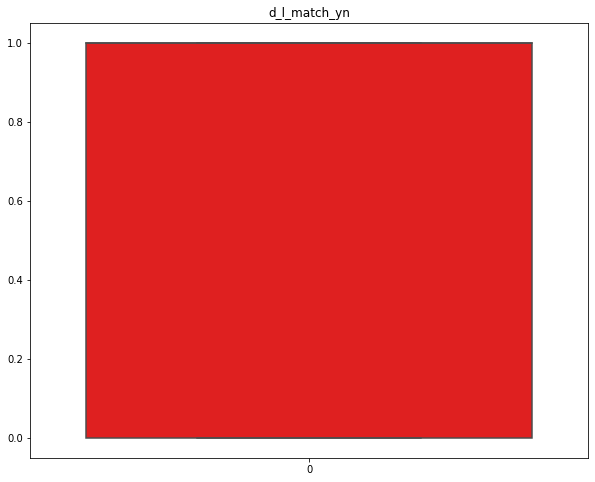

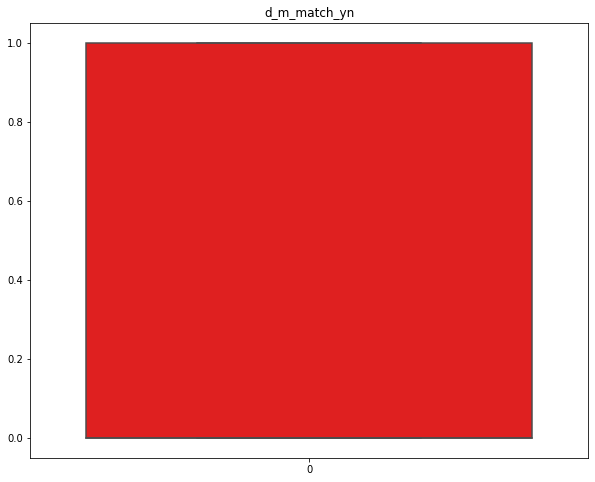

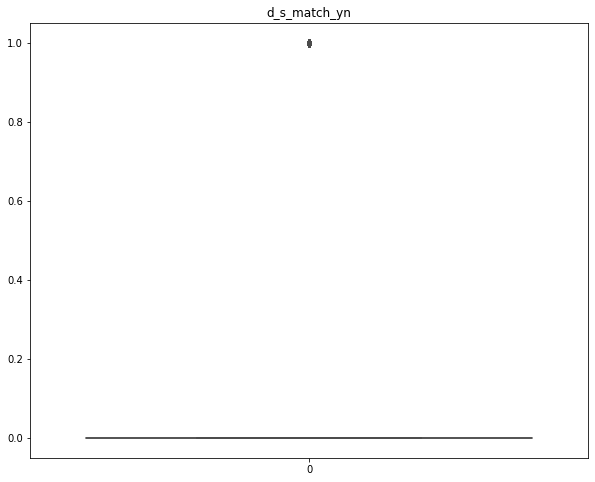

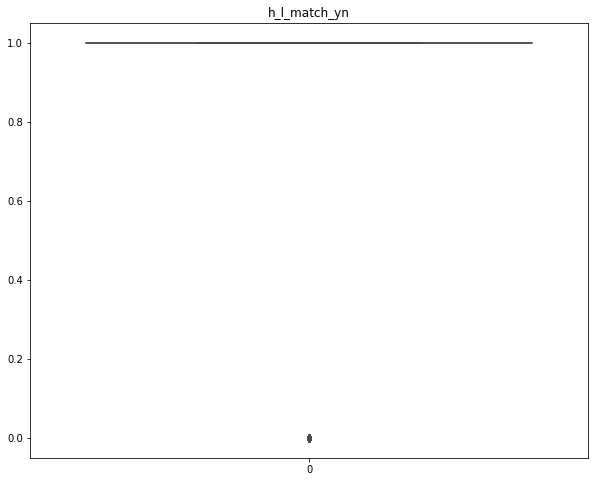

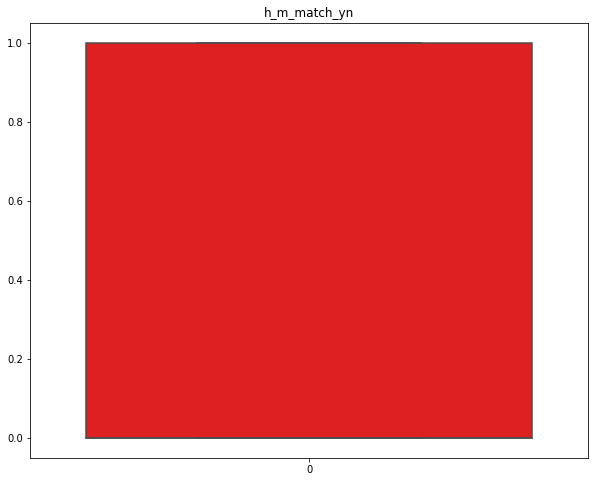

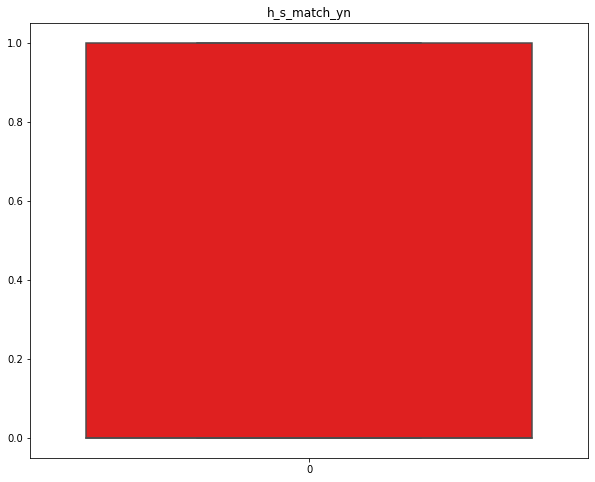

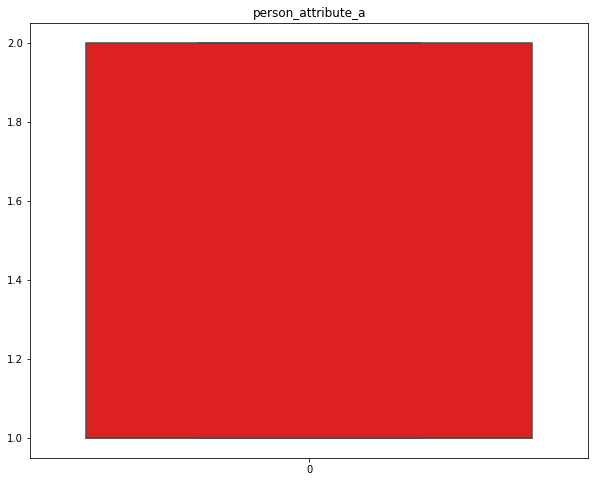

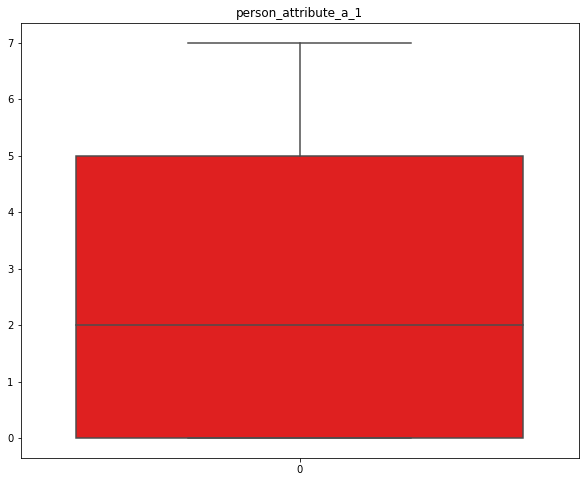

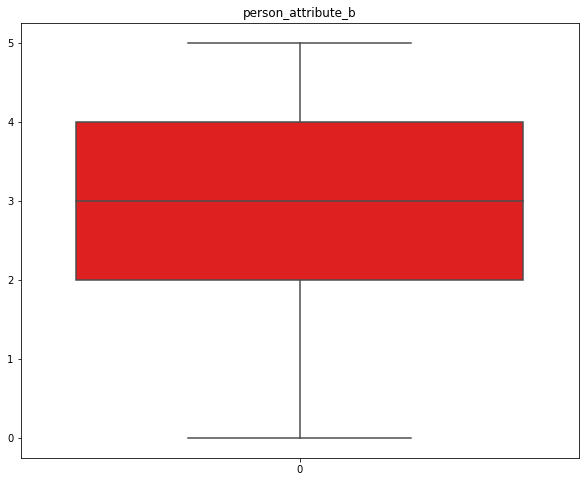

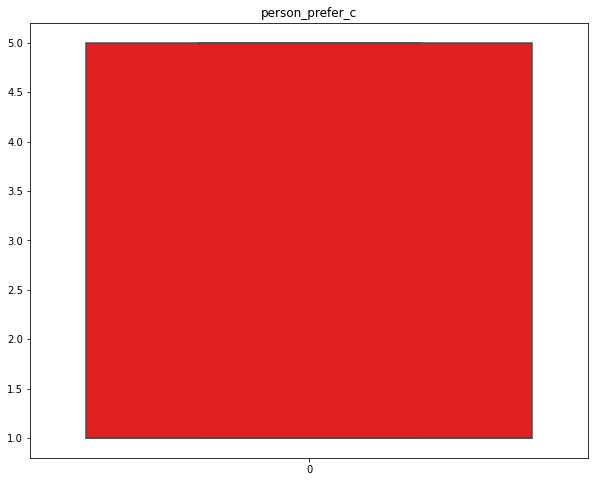

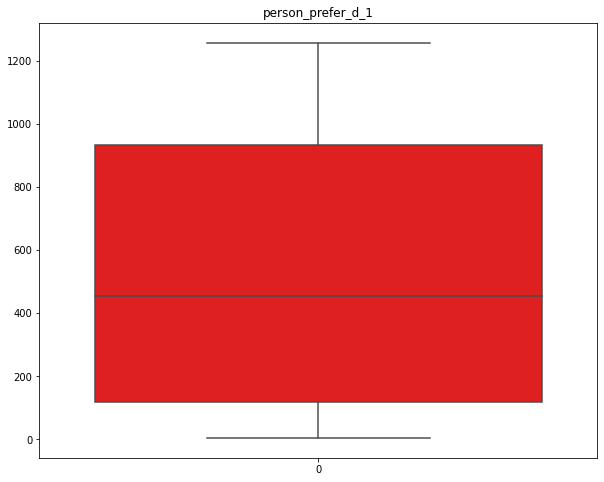

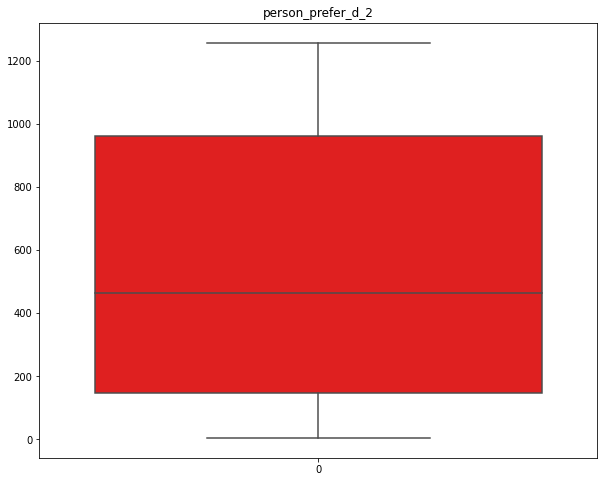

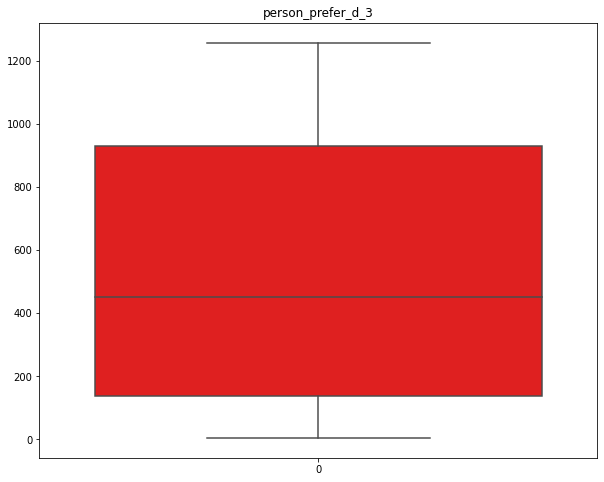

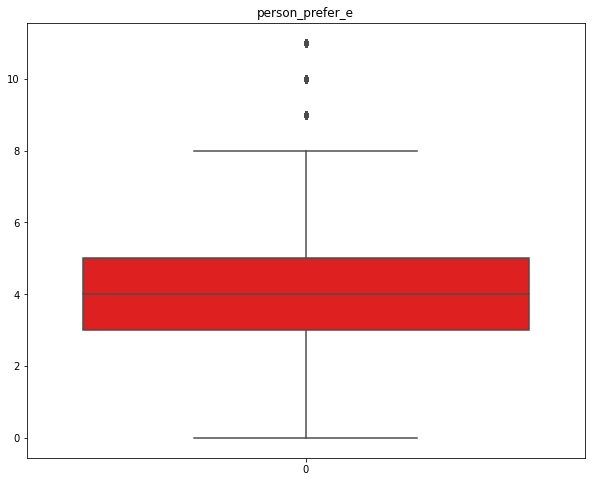

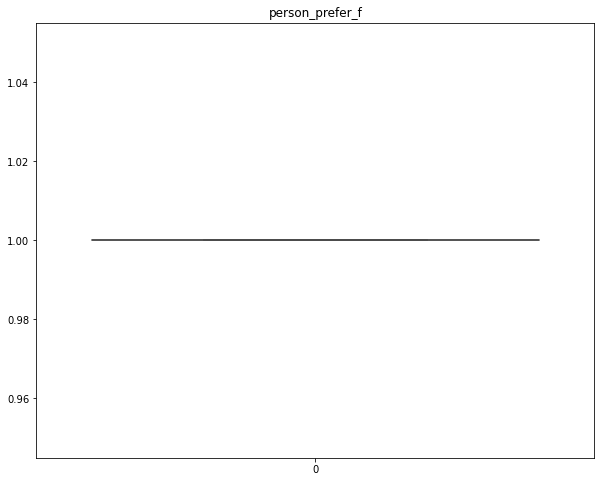

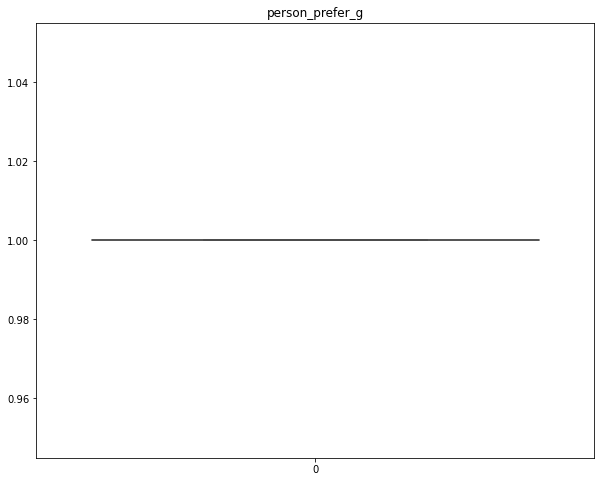

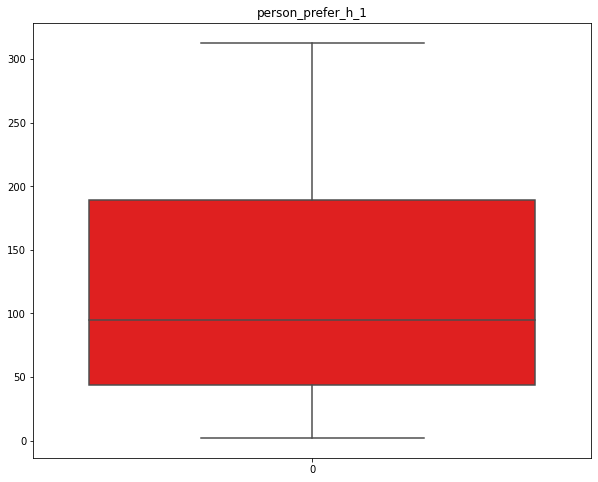

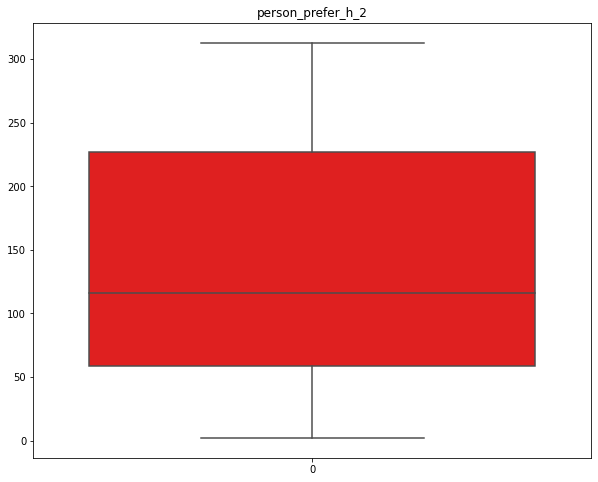

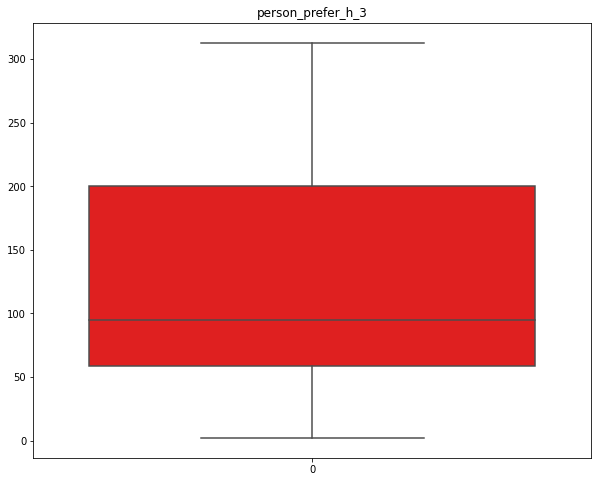

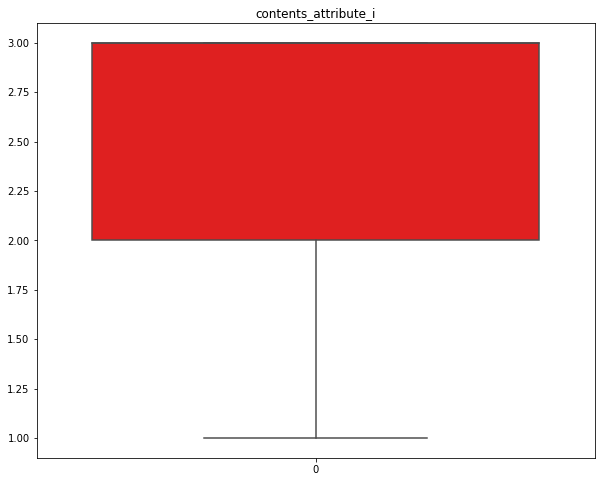

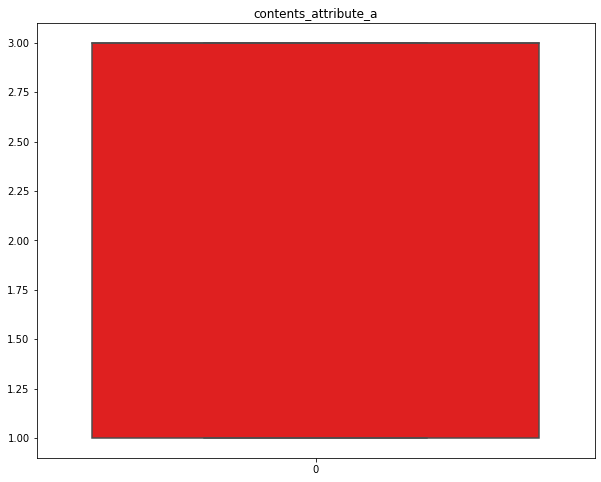

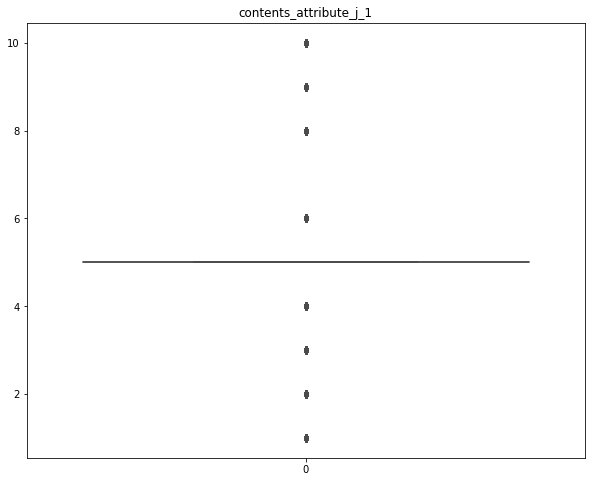

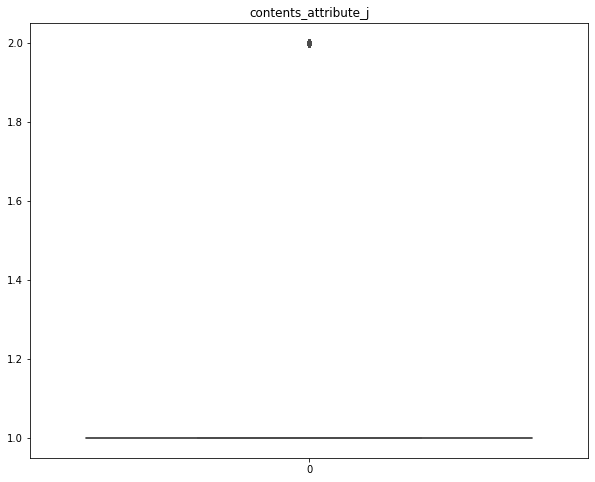

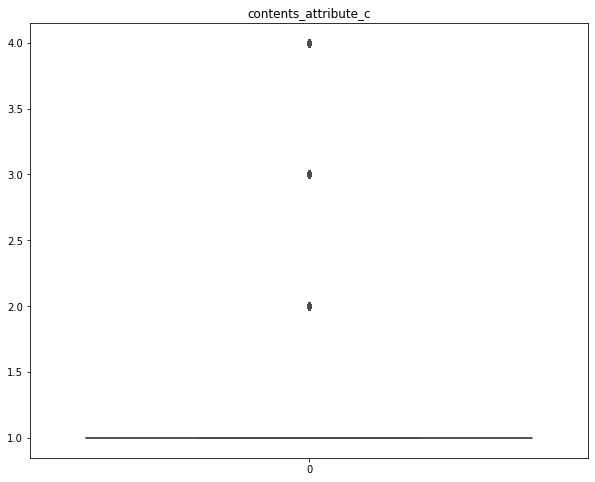

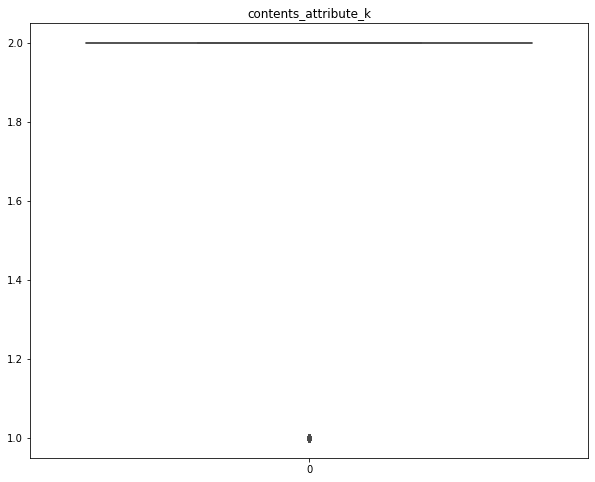

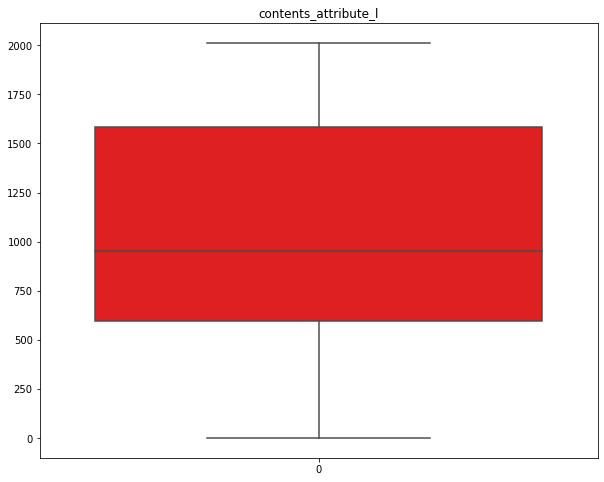

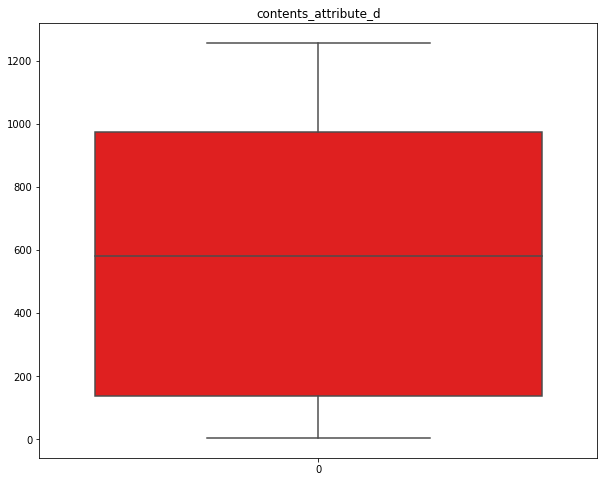

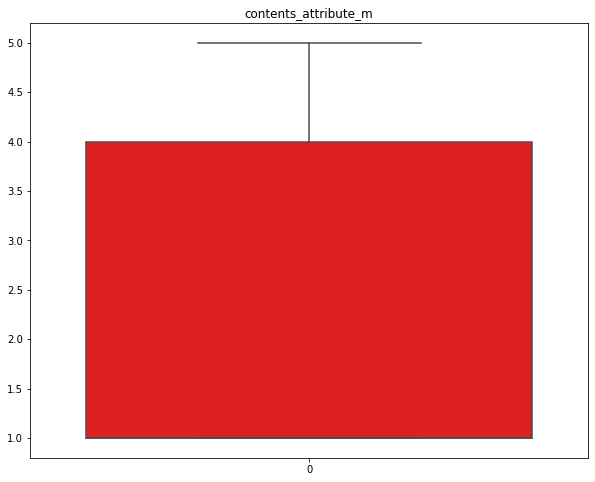

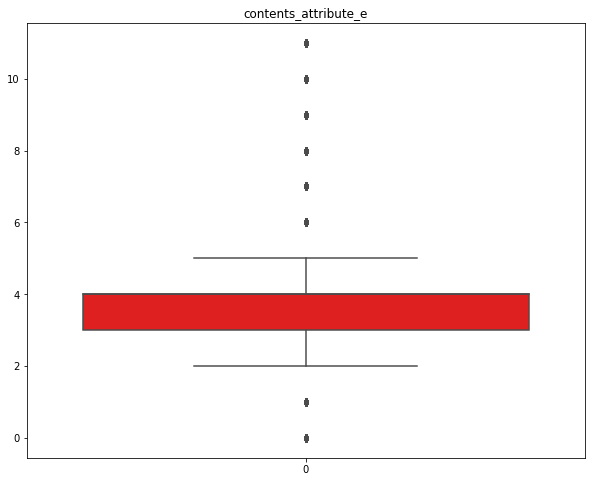

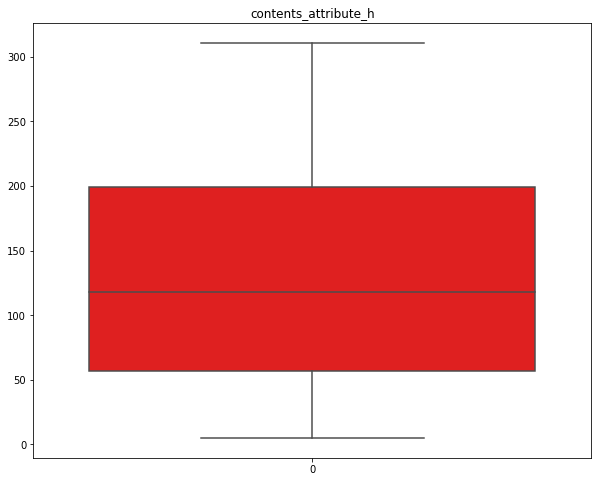

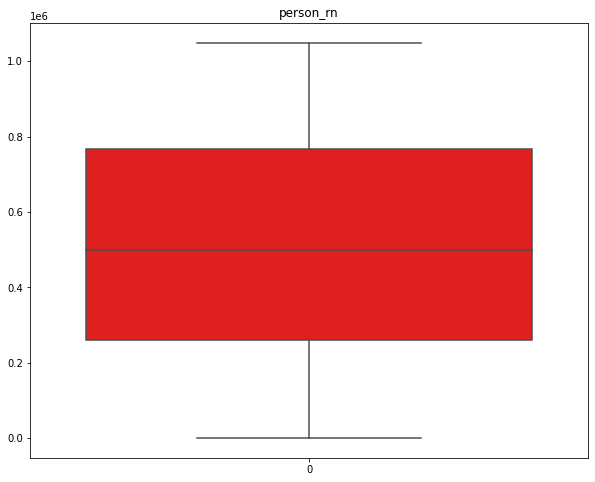

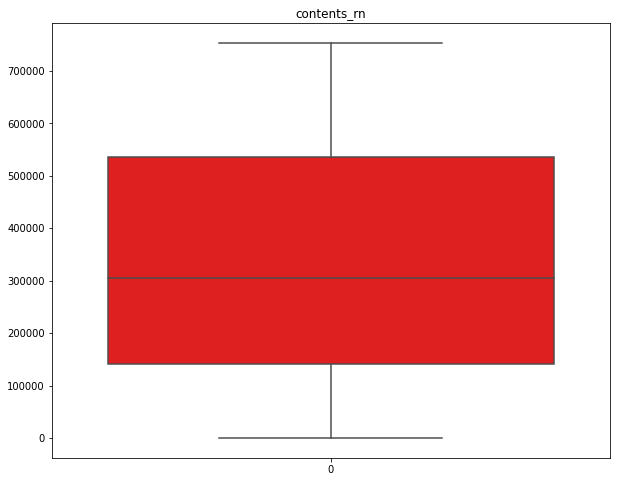

ValueError: could not convert string to float: '2020-01-17 12:09:36'

<Figure size 720x576 with 0 Axes>

In [10]:
def detect_outlier(df):
    for col in df.columns:
        plt.figure(figsize=(10,8))
        sns.boxplot(data=df[col], color='red').set_title(col)
        plt.show()
detect_outlier(train_df)

In [ ]:
#이상치 제거
def remove_outlier(df,column):
    quantile_25 = np.quantile(df[column], 0.25)
    quantile_75 = np.quantile(df[column],0.75)
    IQR = quantile_75 - quantile_25
    minimum = quantile_25 - 1.5 * IQR
    maximum = quantile_75 + 1.5 * IQR
    df_rmout = df[(minimum <= df[column]) & (df[column] <= maximum)]
    return df_rmout

#결측치 처리
def processing_null(df,null_col):
    if method == 'remove':
        df.dropna(how='any')
    else:
        df.fillna({column:df[null_col].mean()})
    return df

# data cleansing & Feature Engineering

In [33]:
class datacleansing():
    def __init__(self,df_list:list,date_col:str):
        self.df_list = df_list
        self.col = date_col
    def bool_to_num(self):
        for df in self.df_list:
            for column in df.select_dtypes(include='bool').columns:
                df[column] = df[column].astype(int)
        return self.df_list
    def date_to_num(self):
        for df in self.df_list:
            df[self.col] = pd.to_datetime(df[self.col])
            df.sort_values(by=self.col,inplace=True)
            df['month'] = pd.DatetimeIndex(df[self.col]).month
            df['day'] = pd.DatetimeIndex(df[self.col]).day
            df['hour'] = pd.DatetimeIndex(df[self.col]).hour
            df['dayofweek'] = df[self.col].dt.dayofweek
        return self.df_list
    def main(self):
        self.df_list = self.bool_to_num()
        self.df_list = self.date_to_num()
        return self.df_list
    
df_list = [train_df,test_df]
clean_module = datacleansing(df_list,'contents_open_dt')
[train_df,test_df] = clean_module.main()
train_df

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target,month,day,hour,dayofweek
82335,82335,0,0,0,1,1,0,2,0,2,5,289,873,910,5,1,1,101,2,96,3,1,5,1,3,2,1648,984,4,5,102,717615,748440,2020-01-01 00:01:03,0,1,1,0,2
459788,459788,1,1,1,0,0,0,1,7,1,1,833,700,840,5,1,1,113,106,21,3,1,5,1,1,2,1285,833,4,7,29,618286,25105,2020-01-01 00:03:51,1,1,1,0,2
138066,138066,1,0,0,1,0,0,1,1,3,1,112,113,120,3,1,1,59,95,4,3,1,4,1,1,2,1582,119,5,3,68,459261,313469,2020-01-01 00:05:48,1,1,1,0,2
488251,488251,1,0,0,1,0,0,1,3,4,5,162,103,159,3,1,1,4,95,59,3,1,5,1,2,2,1648,157,4,0,29,15252,25789,2020-01-01 00:10:19,1,1,1,0,2
398093,398093,0,0,0,1,1,0,2,0,4,5,114,452,175,3,1,1,283,293,280,3,3,3,1,1,2,1851,712,1,3,280,214366,131966,2020-01-01 00:14:14,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403141,403141,0,0,0,1,1,1,2,0,2,2,114,181,175,3,1,1,143,131,140,3,3,5,1,1,2,1027,767,5,4,143,716292,490338,2020-11-30 23:54:05,1,11,30,23,0
220979,220979,1,0,0,0,0,0,1,2,2,1,198,113,209,4,1,1,95,4,59,3,1,10,2,1,2,1582,119,5,5,27,614546,9876,2020-11-30 23:54:58,0,11,30,23,0
361188,361188,0,0,0,1,0,0,1,4,4,1,1078,1080,984,4,1,1,40,37,45,3,1,5,1,3,2,1672,704,4,4,42,191752,102431,2020-11-30 23:55:00,0,11,30,23,0
303341,303341,0,0,0,1,0,0,2,0,2,1,909,910,923,4,1,1,86,31,278,3,1,5,1,3,2,783,998,1,3,90,281138,157764,2020-11-30 23:56:58,0,11,30,23,0


In [35]:
def remove_col(df_list:list,col_list:list):
    for df in df_list:
        df.drop(col_list,axis=1,inplace=True)
    return df_list

train_df,test_df = remove_col([train_df,test_df],['id','person_prefer_f','person_prefer_g','contents_open_dt'])
train_df

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target,month,day,hour,dayofweek
82335,0,0,0,1,1,0,2,0,2,5,289,873,910,5,101,2,96,3,1,5,1,3,2,1648,984,4,5,102,717615,748440,0,1,1,0,2
459788,1,1,1,0,0,0,1,7,1,1,833,700,840,5,113,106,21,3,1,5,1,1,2,1285,833,4,7,29,618286,25105,1,1,1,0,2
138066,1,0,0,1,0,0,1,1,3,1,112,113,120,3,59,95,4,3,1,4,1,1,2,1582,119,5,3,68,459261,313469,1,1,1,0,2
488251,1,0,0,1,0,0,1,3,4,5,162,103,159,3,4,95,59,3,1,5,1,2,2,1648,157,4,0,29,15252,25789,1,1,1,0,2
398093,0,0,0,1,1,0,2,0,4,5,114,452,175,3,283,293,280,3,3,3,1,1,2,1851,712,1,3,280,214366,131966,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403141,0,0,0,1,1,1,2,0,2,2,114,181,175,3,143,131,140,3,3,5,1,1,2,1027,767,5,4,143,716292,490338,1,11,30,23,0
220979,1,0,0,0,0,0,1,2,2,1,198,113,209,4,95,4,59,3,1,10,2,1,2,1582,119,5,5,27,614546,9876,0,11,30,23,0
361188,0,0,0,1,0,0,1,4,4,1,1078,1080,984,4,40,37,45,3,1,5,1,3,2,1672,704,4,4,42,191752,102431,0,11,30,23,0
303341,0,0,0,1,0,0,2,0,2,1,909,910,923,4,86,31,278,3,1,5,1,3,2,783,998,1,3,90,281138,157764,0,11,30,23,0


In [51]:
def add_code(df, d_code, h_code, l_code):
    
    # Copy input data
#     df = df.copy()   

    # D Code
    df['person_prefer_d_1_n'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_1_s'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_1_m'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_1_l'] = df['person_prefer_d_1'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_2_n'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_2_s'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_2_m'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_2_l'] = df['person_prefer_d_2'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['person_prefer_d_3_n'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['person_prefer_d_3_s'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['person_prefer_d_3_m'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['person_prefer_d_3_l'] = df['person_prefer_d_3'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    df['contents_attribute_d_n'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 세분류코드'])
    df['contents_attribute_d_s'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 소분류코드'])
    df['contents_attribute_d_m'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 중분류코드'])
    df['contents_attribute_d_l'] = df['contents_attribute_d'].apply(lambda x: d_code[x]['속성 D 대분류코드'])

    # H Code
    df['person_prefer_h_1_l'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_1_m'] = df['person_prefer_h_1'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_2_l'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_2_m'] = df['person_prefer_h_2'].apply(lambda x: h_code[x]['속성 H 중분류코드'])
    
    df['person_prefer_h_3_l'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['person_prefer_h_3_m'] = df['person_prefer_h_3'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    df['contents_attribute_h_l'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 대분류코드'])
    df['contents_attribute_h_m'] = df['contents_attribute_h'].apply(lambda x: h_code[x]['속성 H 중분류코드'])

    # L Code
    df['contents_attribute_l_n'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 세분류코드'])
    df['contents_attribute_l_s'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 소분류코드'])
    df['contents_attribute_l_m'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 중분류코드'])
    df['contents_attribute_l_l'] = df['contents_attribute_l'].apply(lambda x: l_code[x]['속성 L 대분류코드'])
    
    return df

In [41]:
d_code = pd.read_csv('/workspace/DBP/NAS저장공간/hengbee/jobcare/D_code.csv', index_col=0).T.to_dict()
h_code = pd.read_csv('/workspace/DBP/NAS저장공간/hengbee/jobcare/H_code.csv', index_col=0).T.to_dict()
l_code = pd.read_csv('/workspace/DBP/NAS저장공간/hengbee/jobcare/L_code.csv', index_col=0).T.to_dict()
d_code

{4: {'속성 D 세분류코드': 4, '속성 D 소분류코드': 3, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 5: {'속성 D 세분류코드': 5, '속성 D 소분류코드': 3, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 7: {'속성 D 세분류코드': 7, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 8: {'속성 D 세분류코드': 8, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 9: {'속성 D 세분류코드': 8, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 10: {'속성 D 세분류코드': 8, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 11: {'속성 D 세분류코드': 8, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 12: {'속성 D 세분류코드': 8, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 13: {'속성 D 세분류코드': 8, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 14: {'속성 D 세분류코드': 14, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 15: {'속성 D 세분류코드': 15, '속성 D 소분류코드': 6, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 17: {'속성 D 세분류코드': 17, '속성 D 소분류코드': 16, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 18: {'속성 D 세분류코드': 18, '속성 D 소분류코드': 16, '속성 D 중분류코드': 2, '속성 D 대분류코드': 1},
 19: {'속성 D 세분류코드': 19, 

In [52]:
train_data = add_code(train_df, d_code, h_code, l_code)
test_data = add_code(test_df, d_code, h_code, l_code)
print("train_data.shape: ", train_data.shape)
print("test_data.shape: ", test_data.shape)

train_data.shape:  (501951, 63)
test_data.shape:  (46404, 62)


# train set에서 라벨 분리

In [ ]:
label = train_data['target']
train_df.drop('target',inplace=True,axis=1)
print("train_data.shape: ", train_df.shape)
print("test_data.shape: ", test_df.shape)

# 라벨값 분포 확인

0    251106
1    250845
Name: target, dtype: int64


<AxesSubplot:title={'center':'Distribution Of Target'}, ylabel='Frequency'>

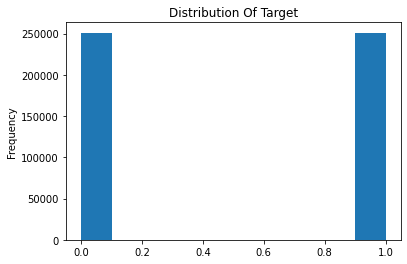

In [59]:
print(label.value_counts())
label.plot.hist(title = "Distribution Of Target")

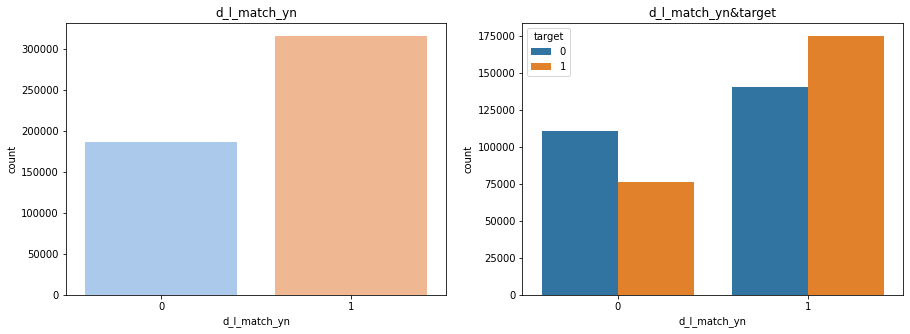

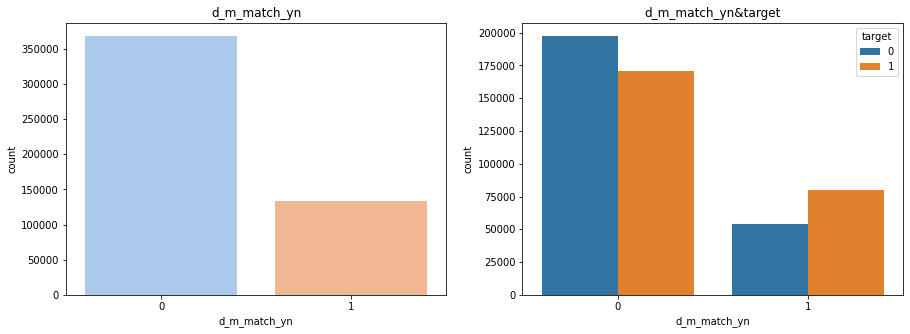

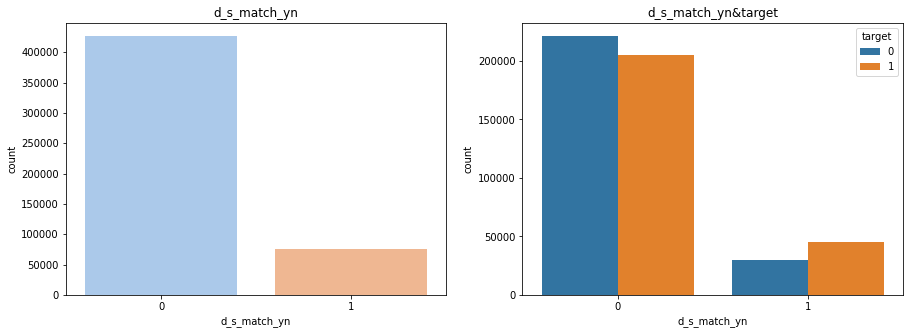

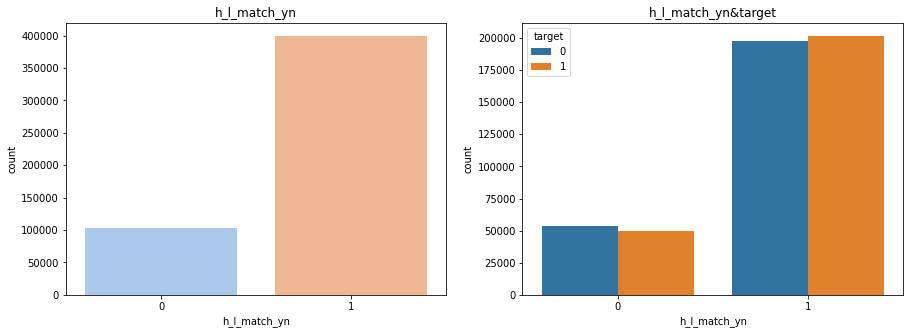

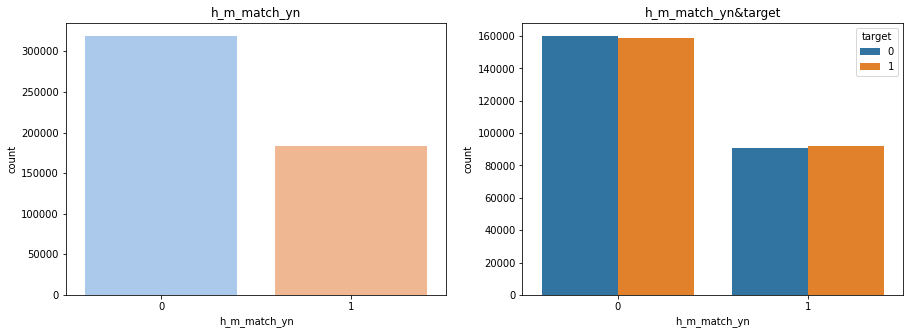

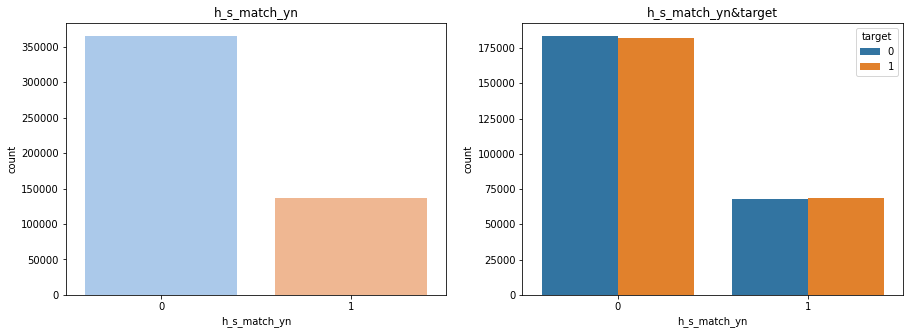

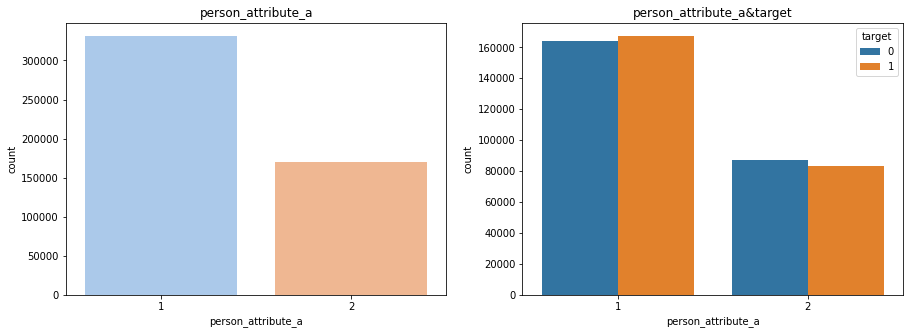

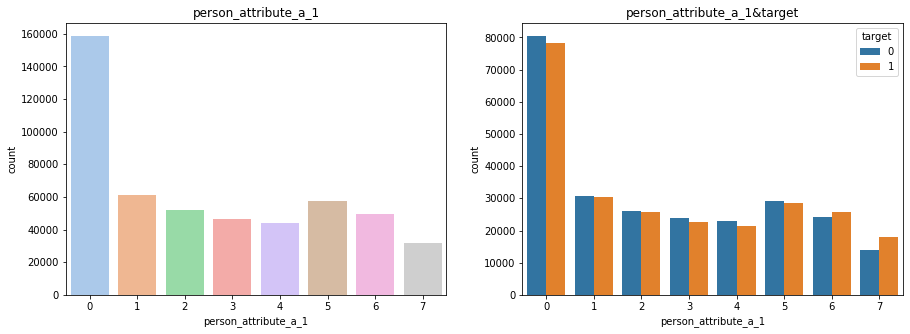

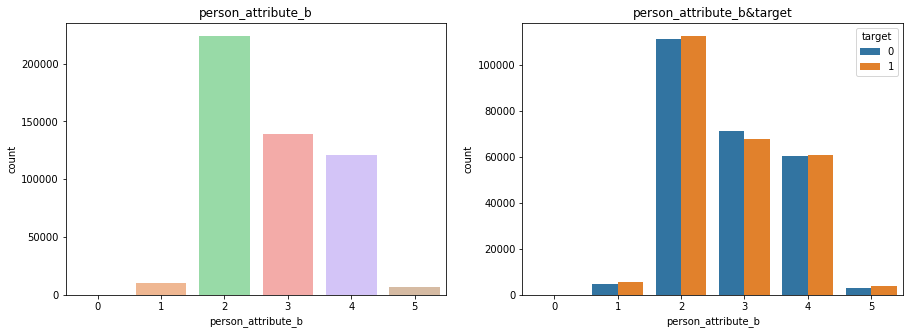

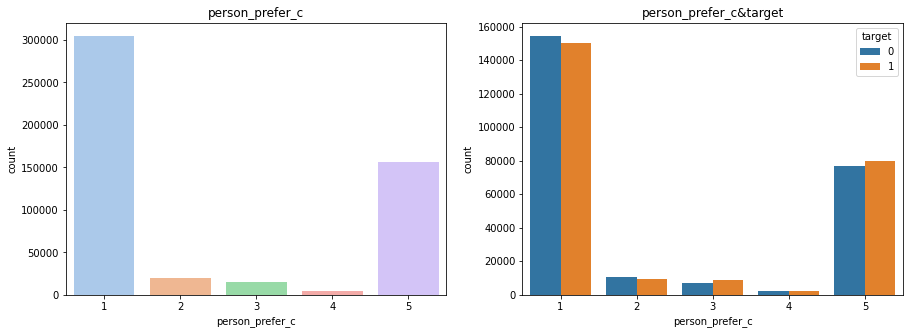

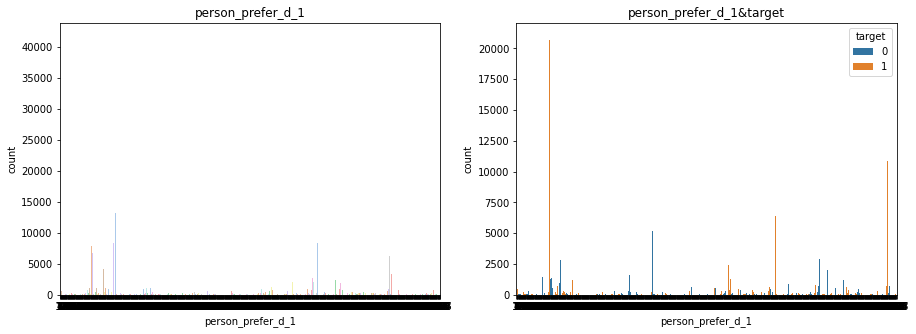

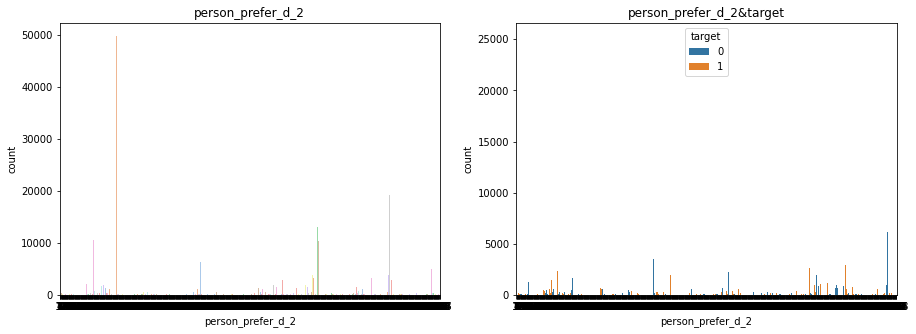

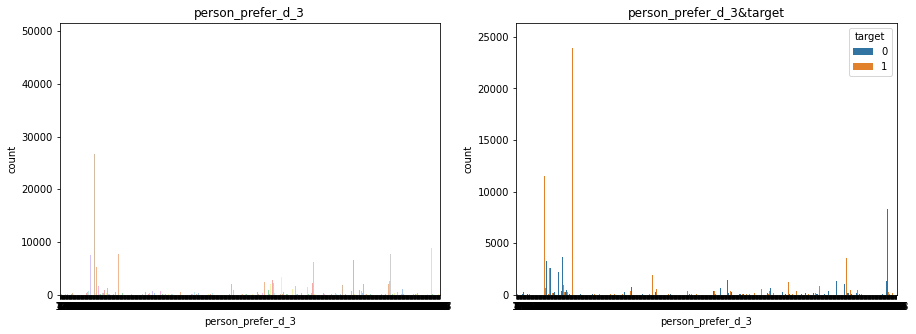

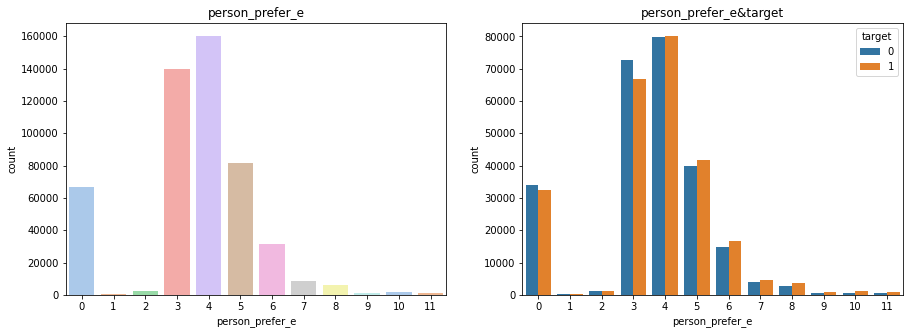

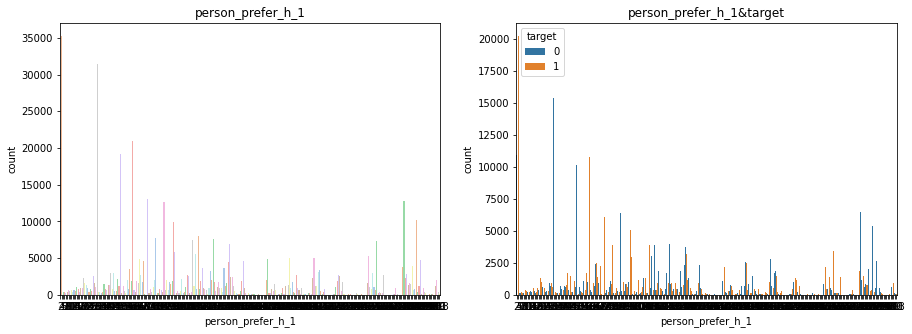

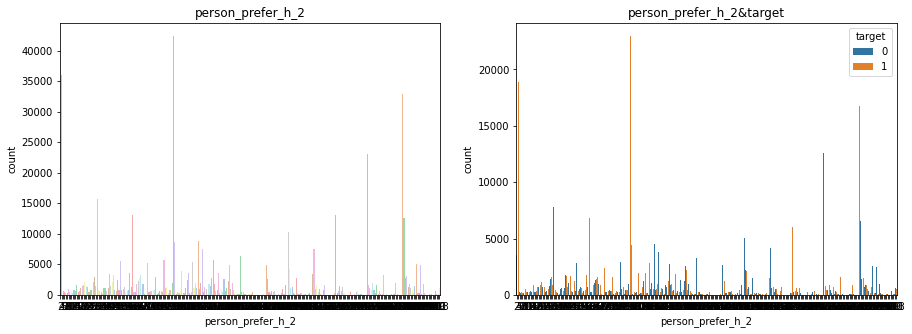

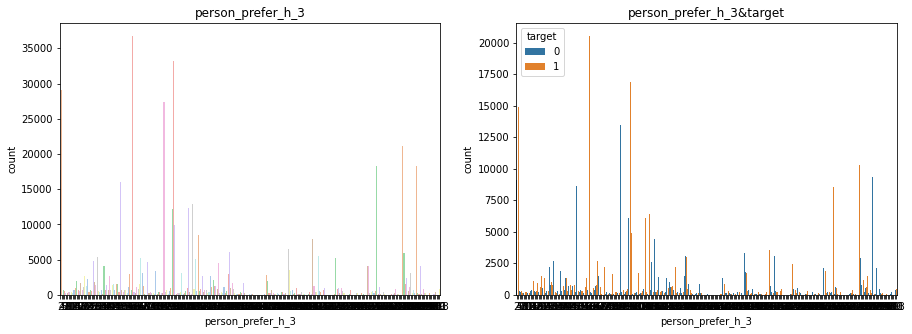

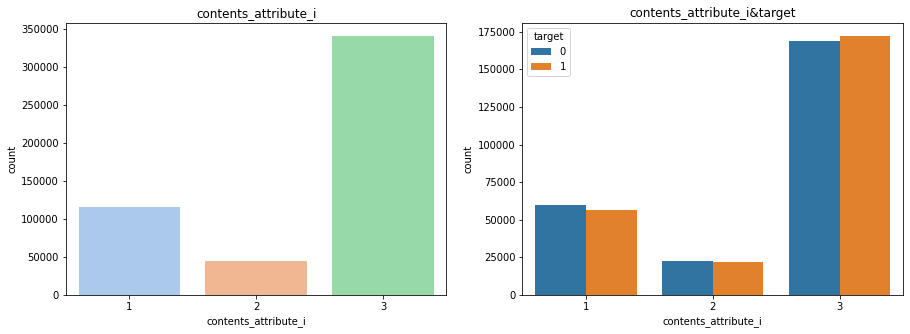

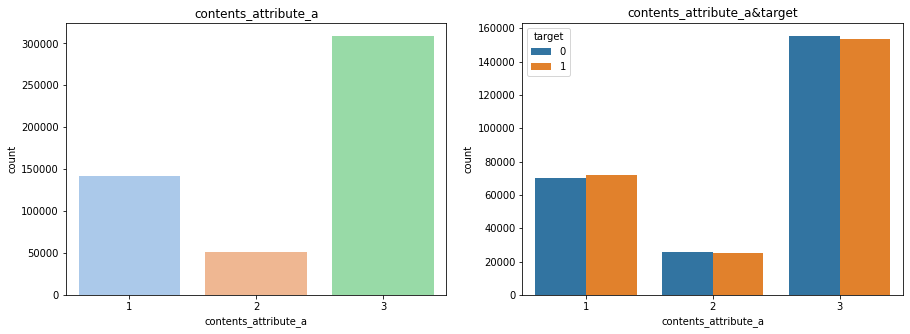

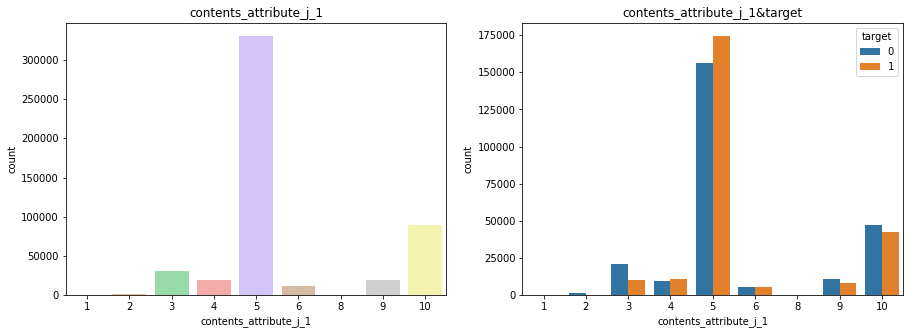

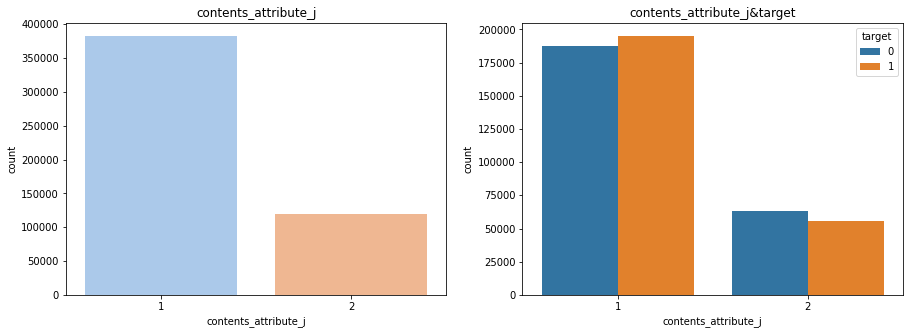

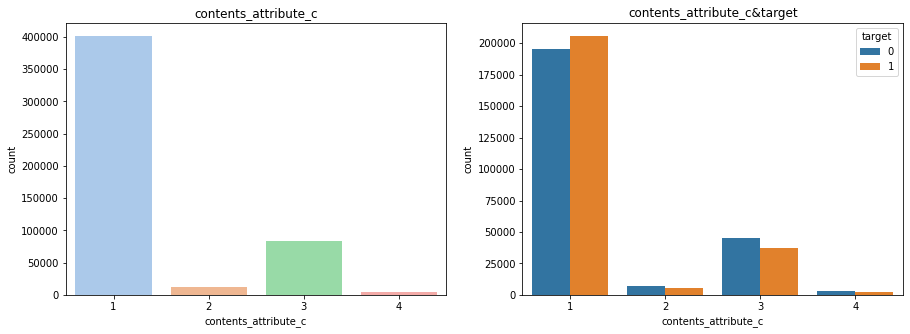

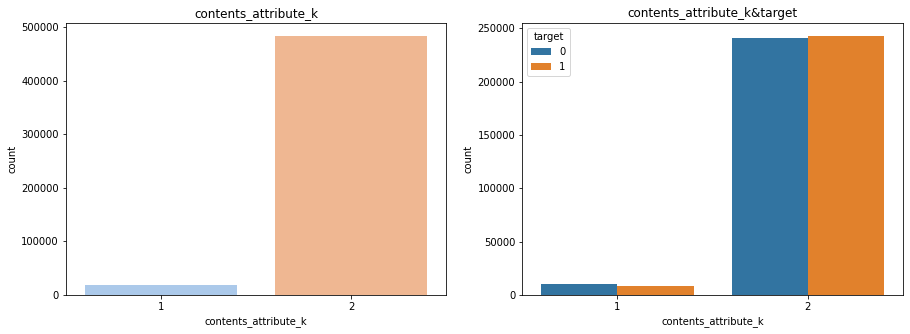

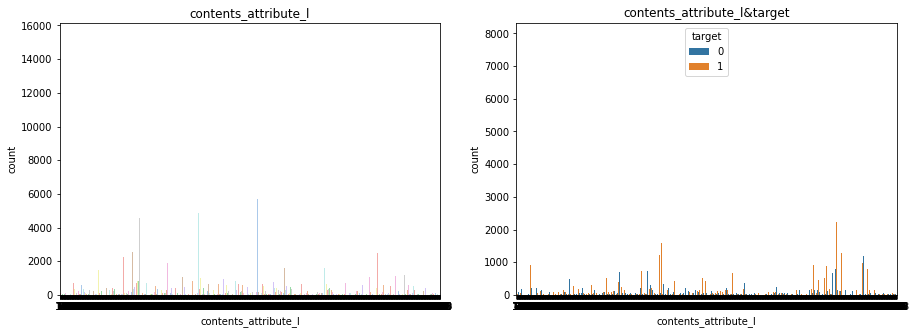

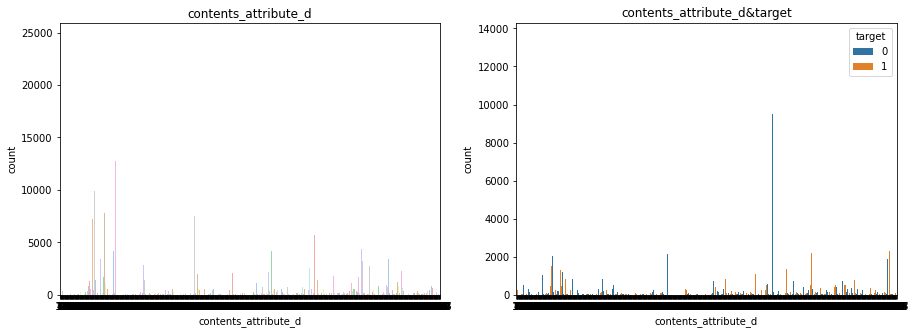

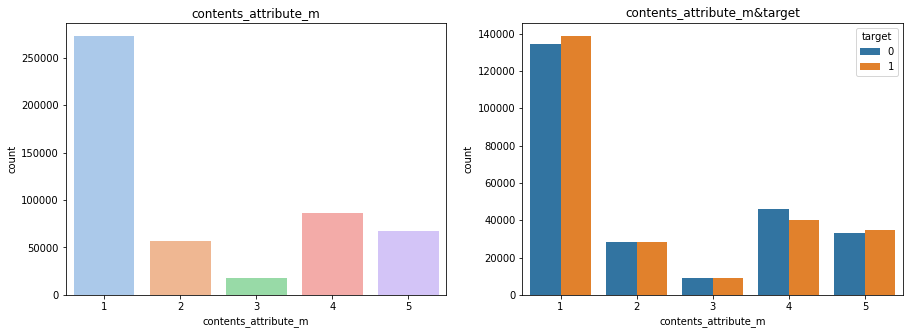

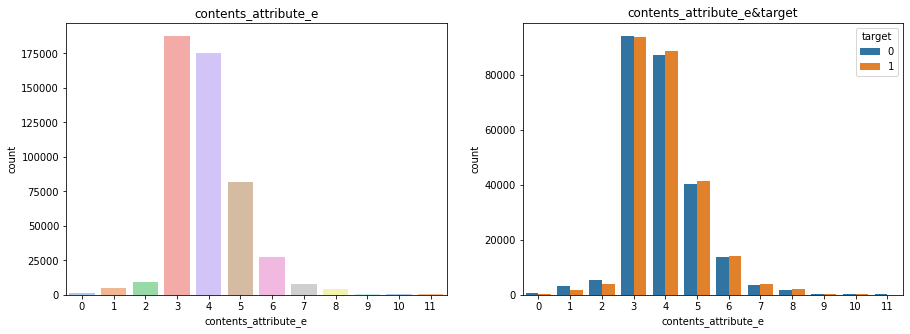

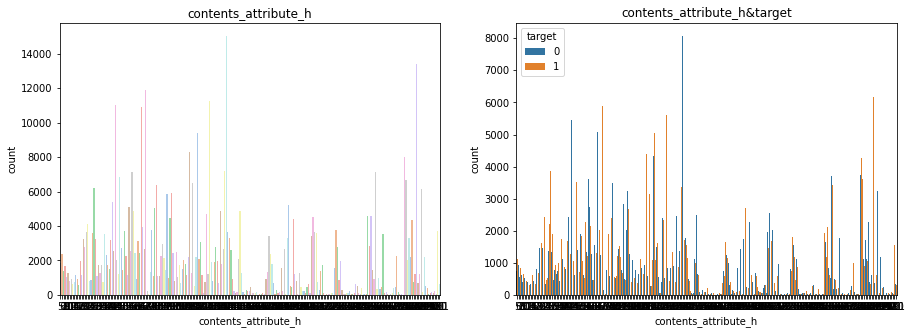

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7efc024b26a8>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py", line 200, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7efc2ffd12f0> (for post_execute):


KeyboardInterrupt: 

In [66]:
def show_distribute(df,label):
    for col in df.columns:
        f, ax = plt.subplots(1, 2, figsize = (15, 5))
        sns.countplot(col, data = df, palette='pastel',ax= ax[0]).set_title(col)
        sns.countplot(col, hue = label, data = df, ax = ax[1]).set_title(col+'&target')
        plt.show()
show_distribute(train_df,label)

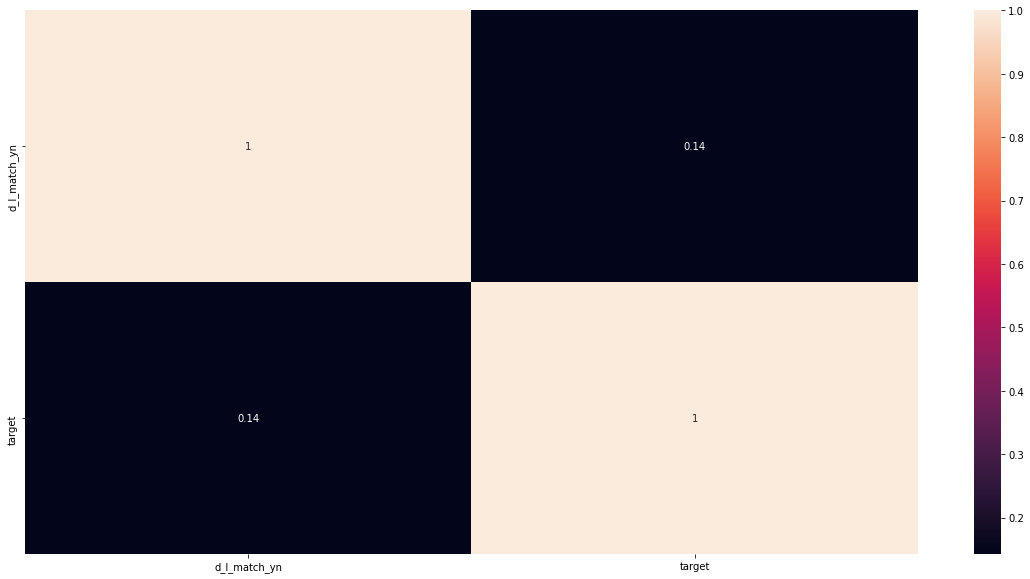

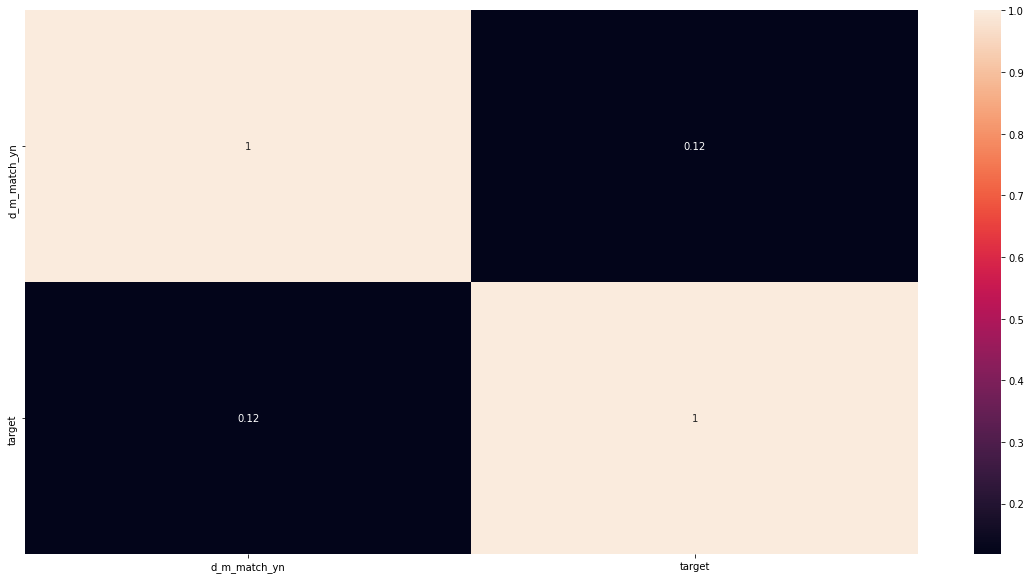

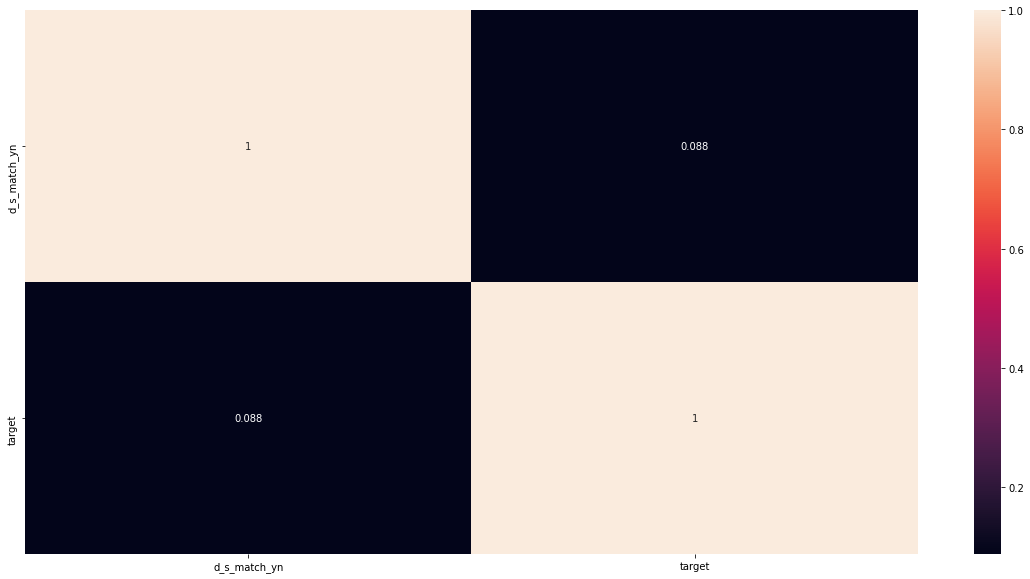

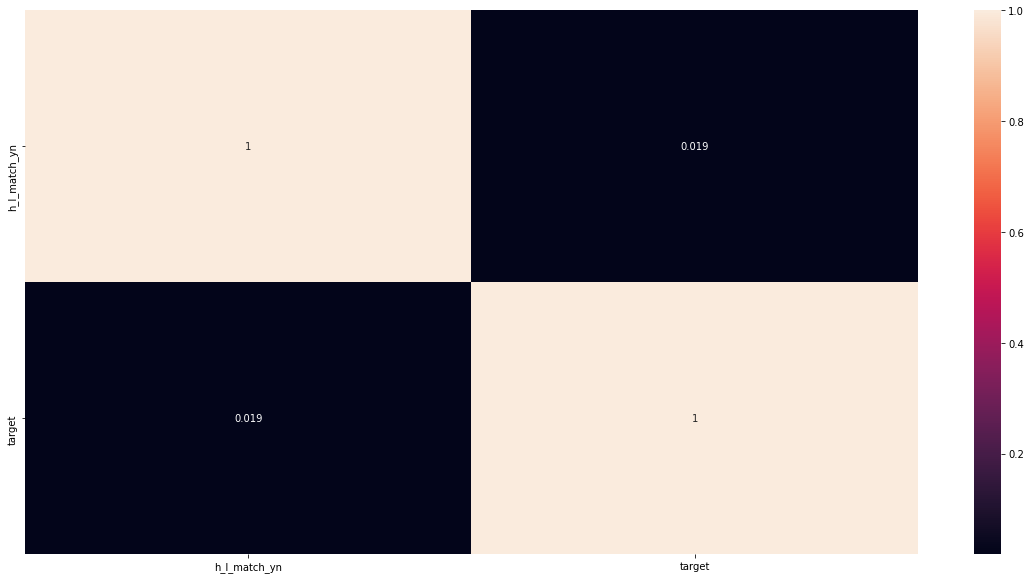

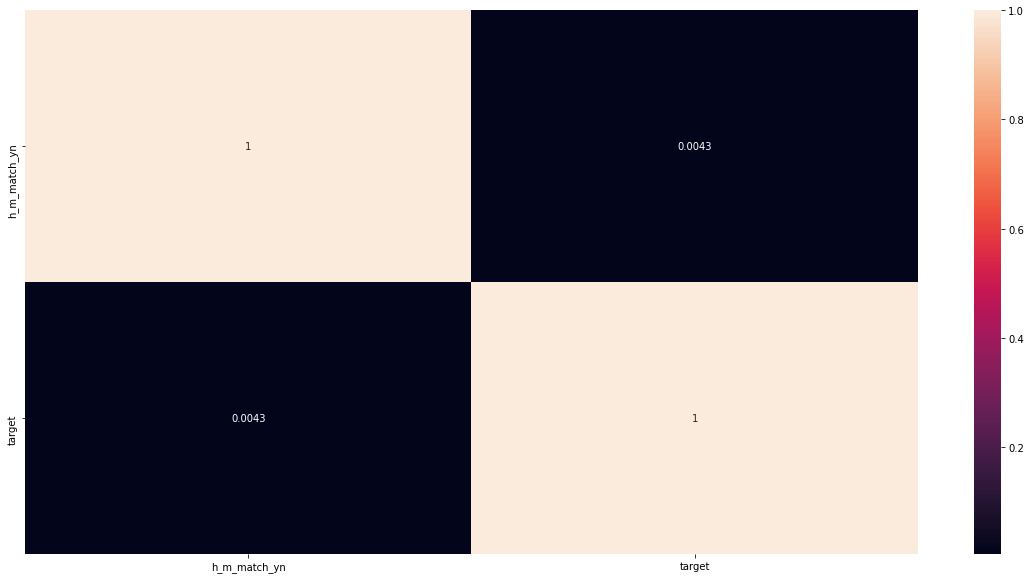

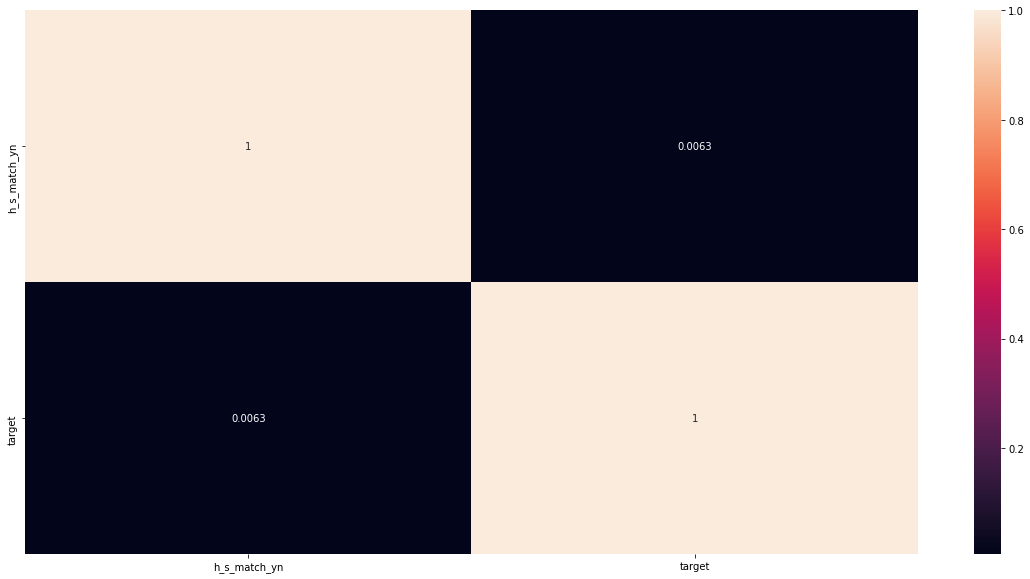

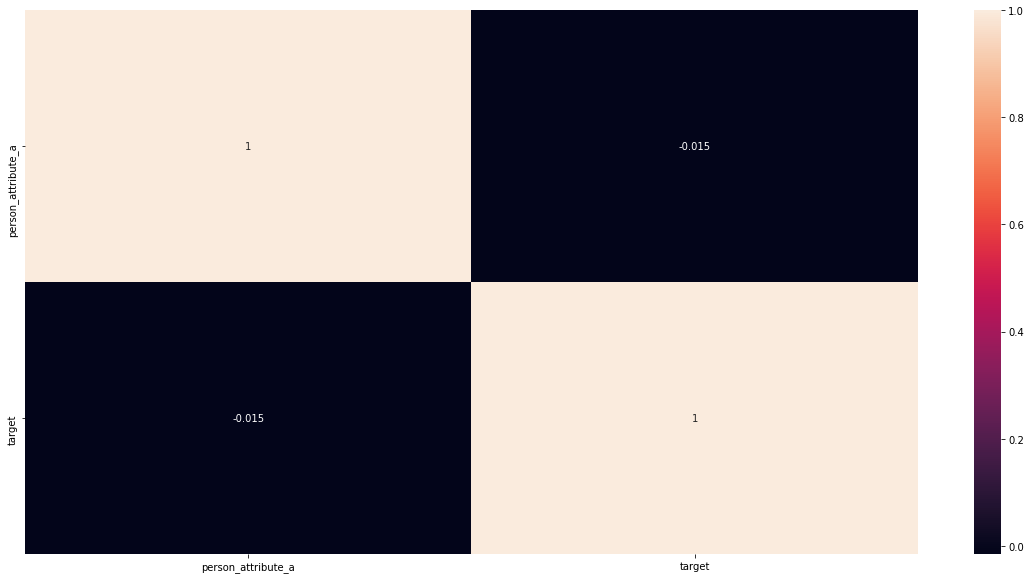

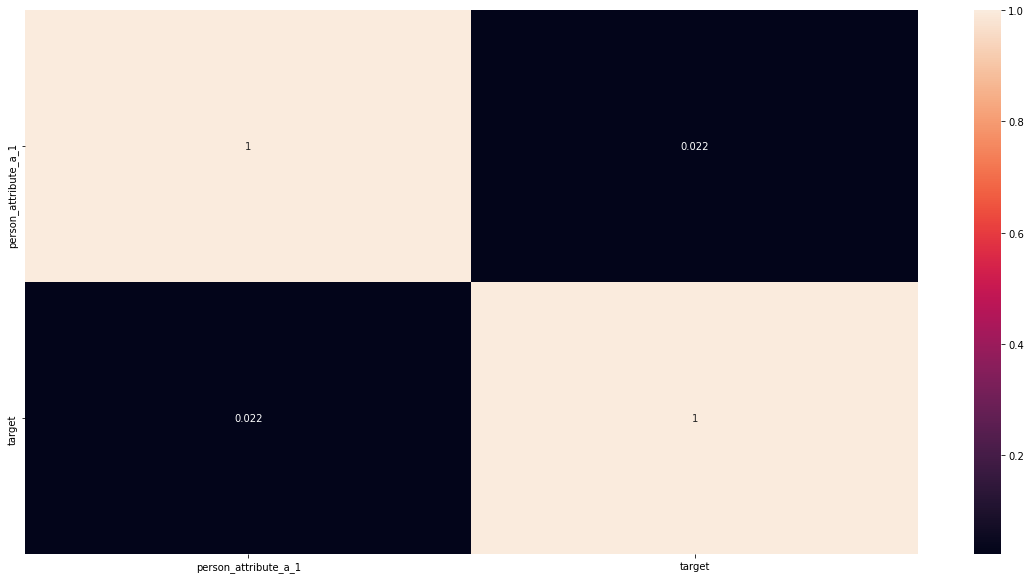

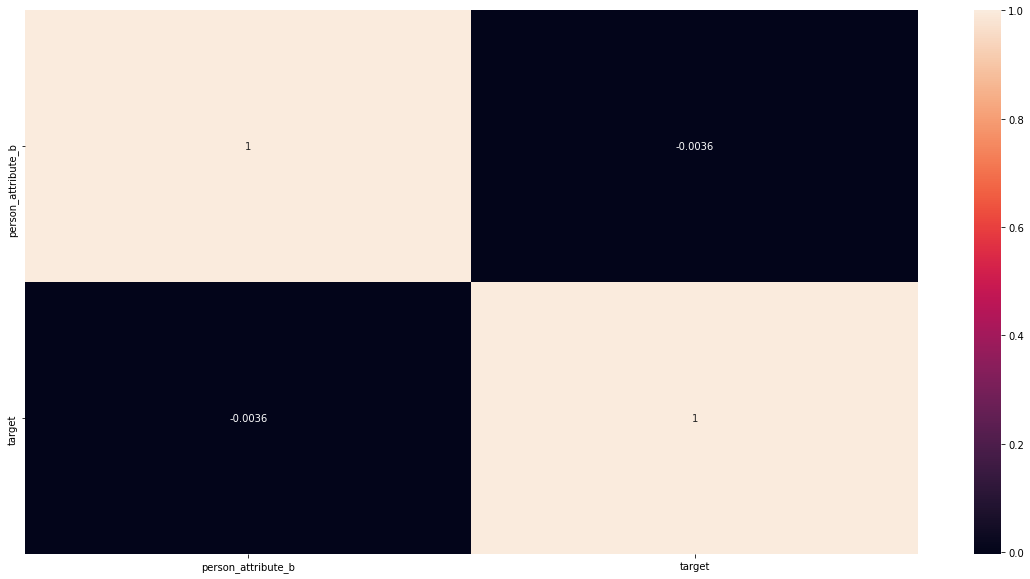

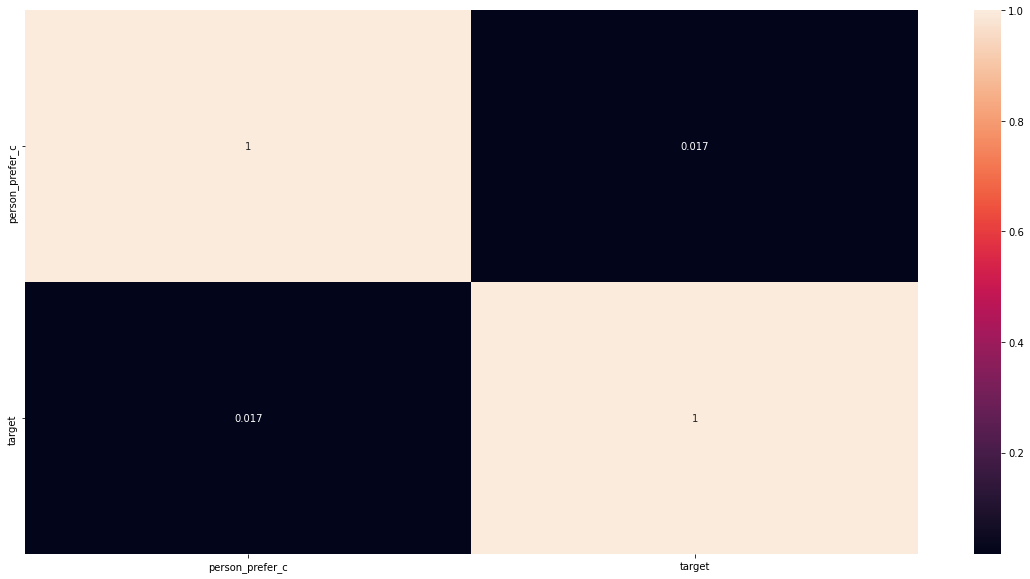

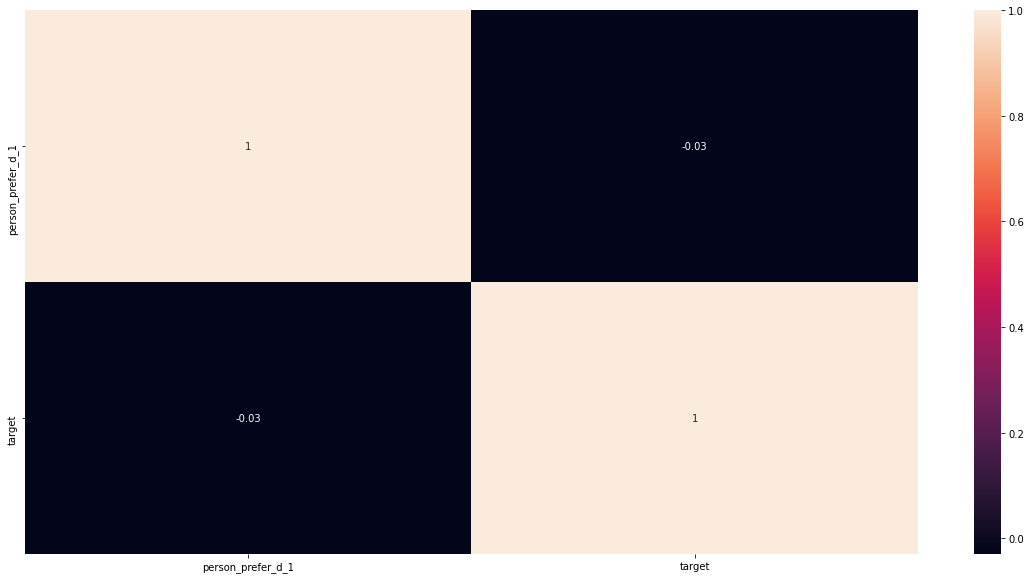

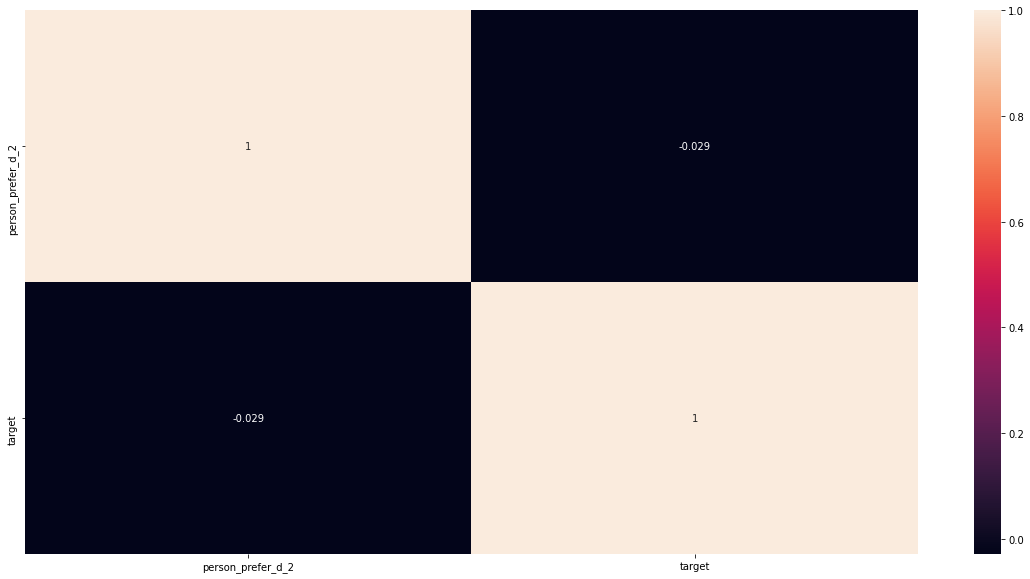

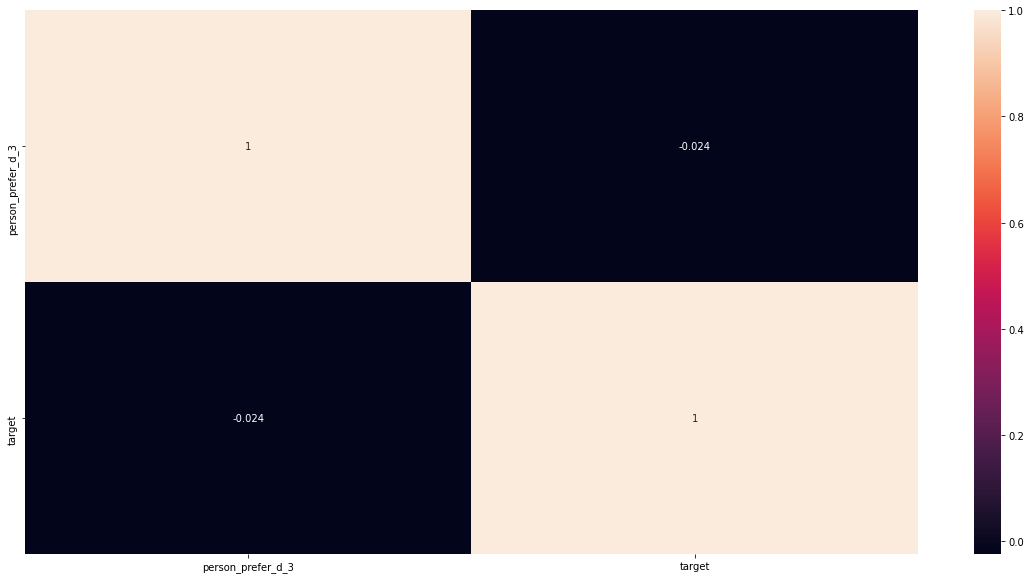

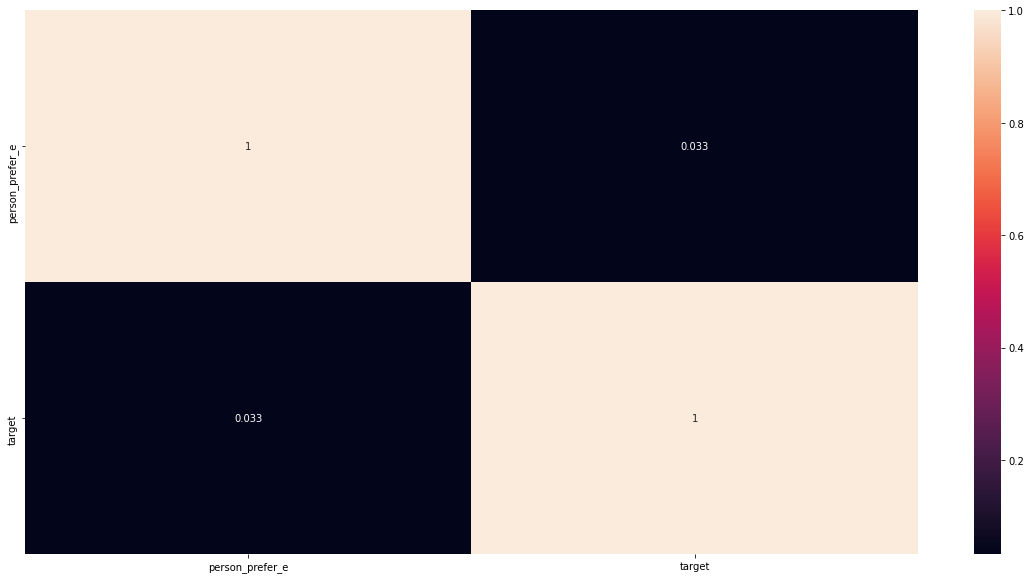

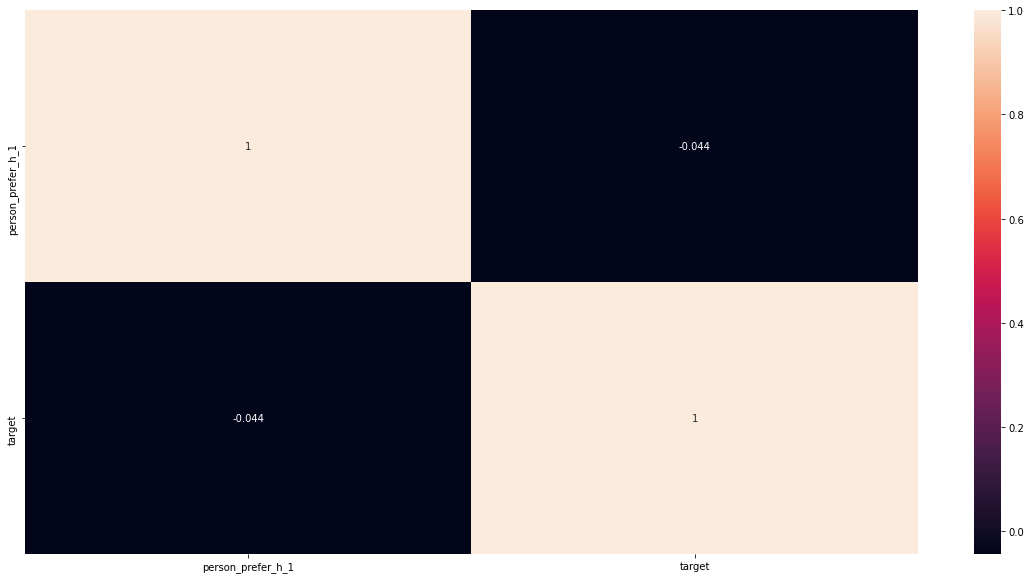

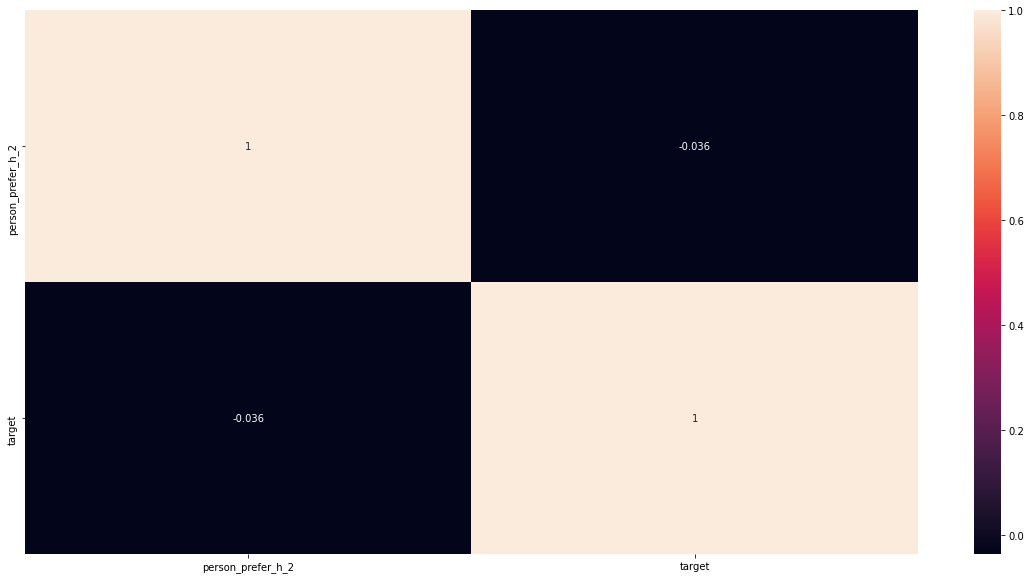

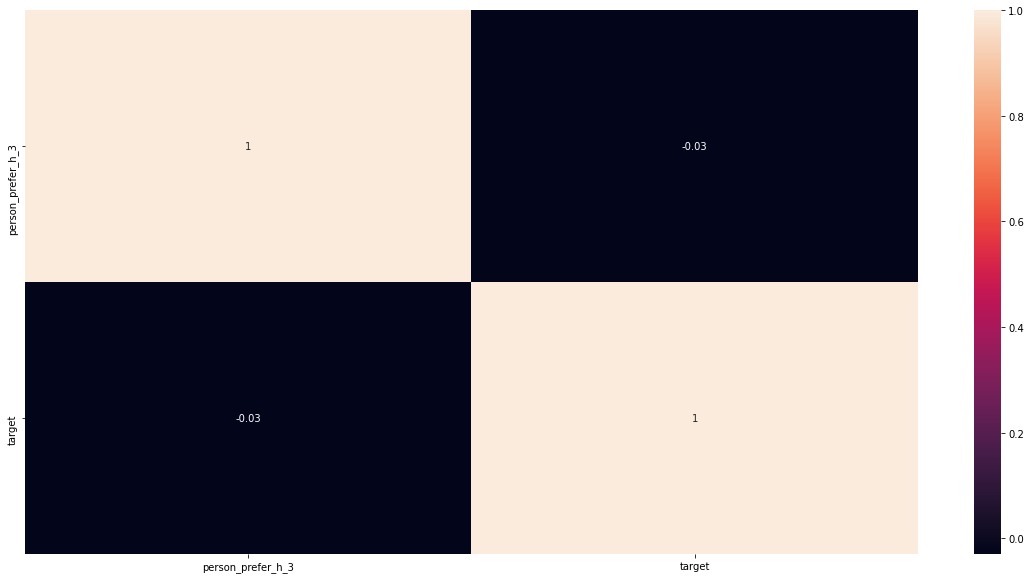

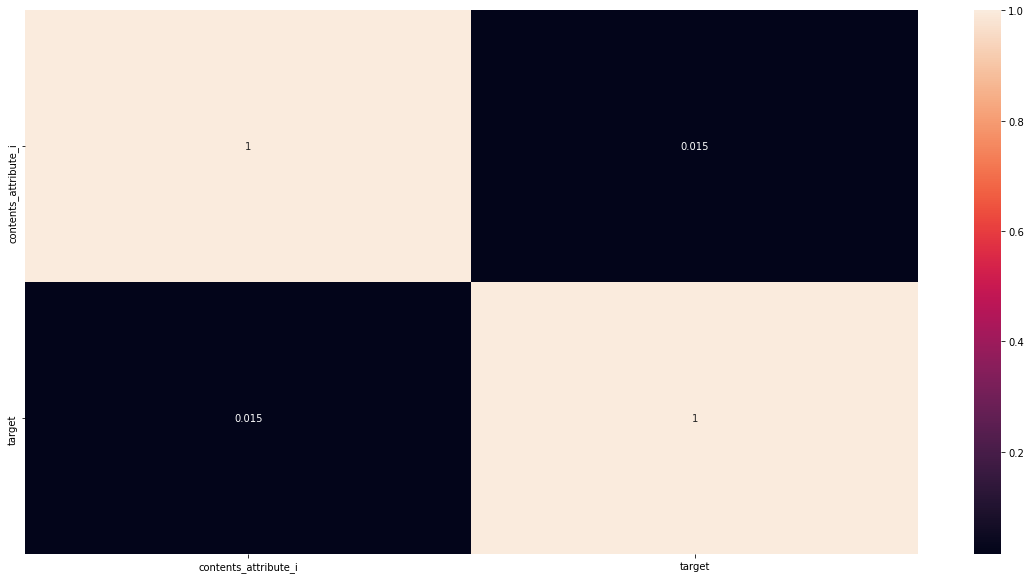

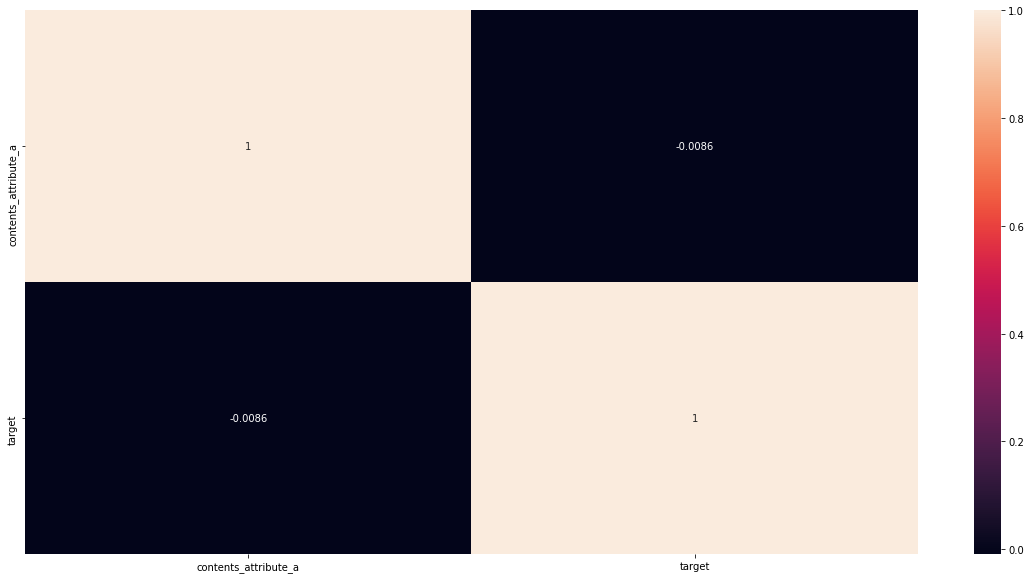

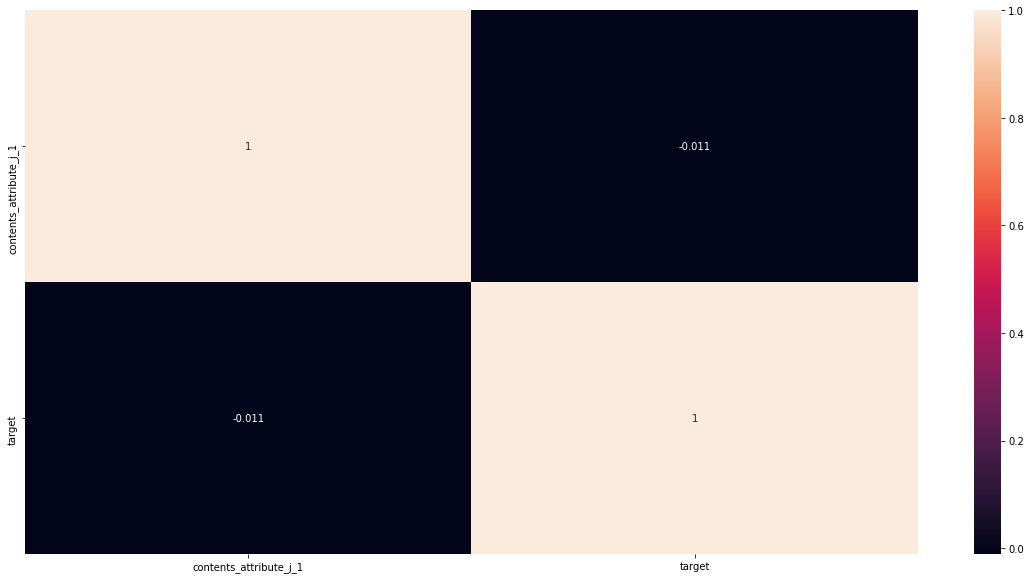

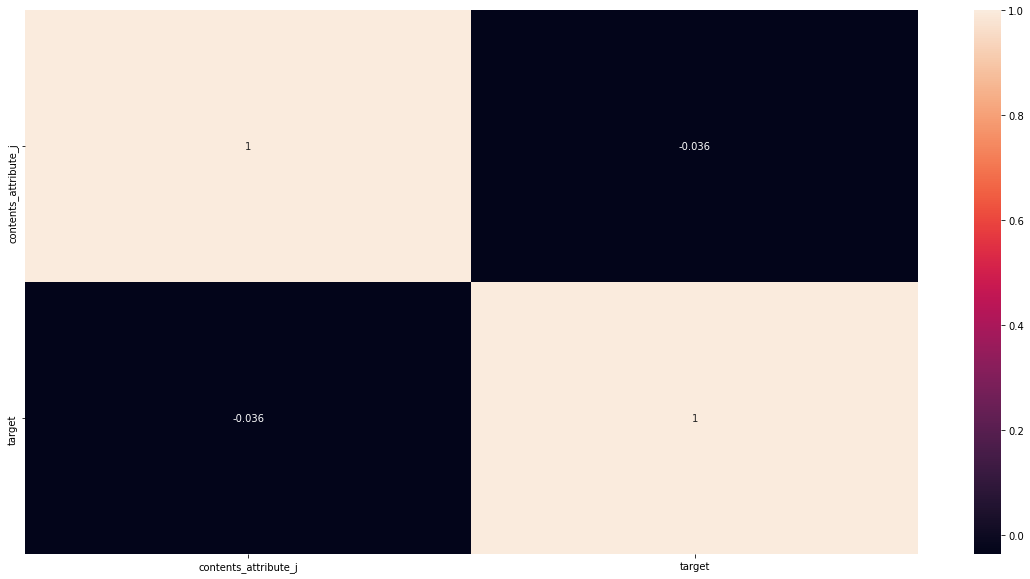

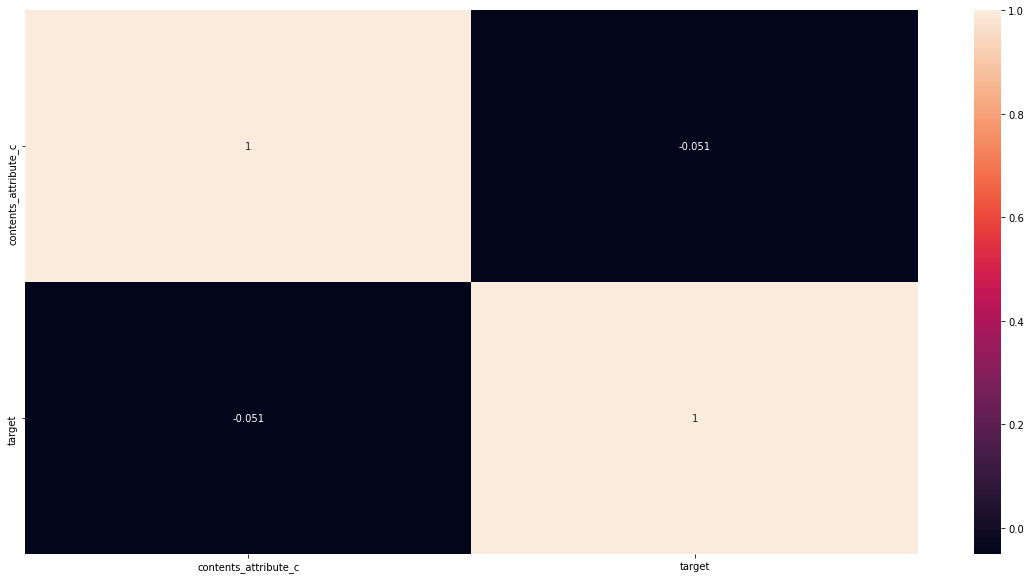

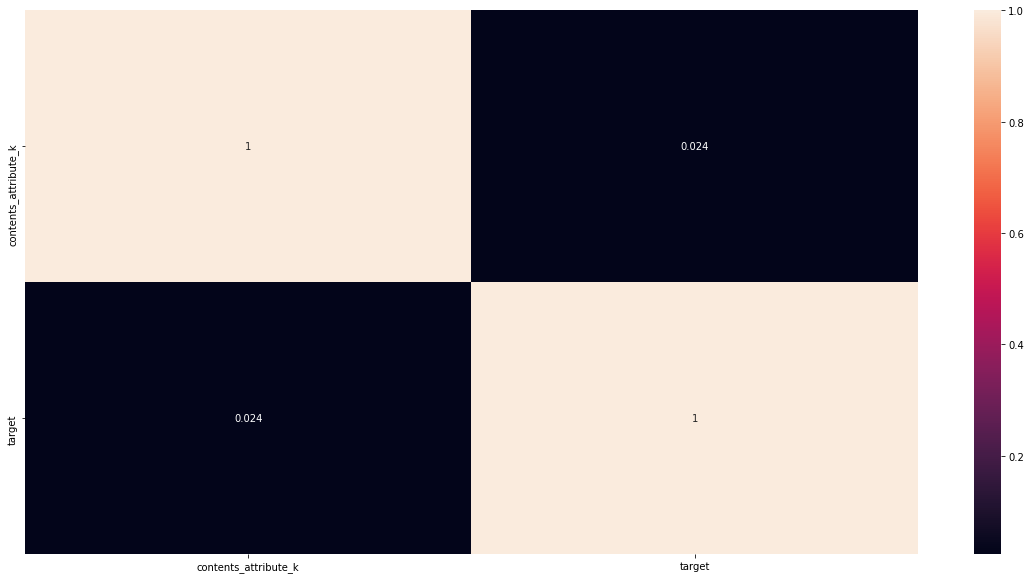

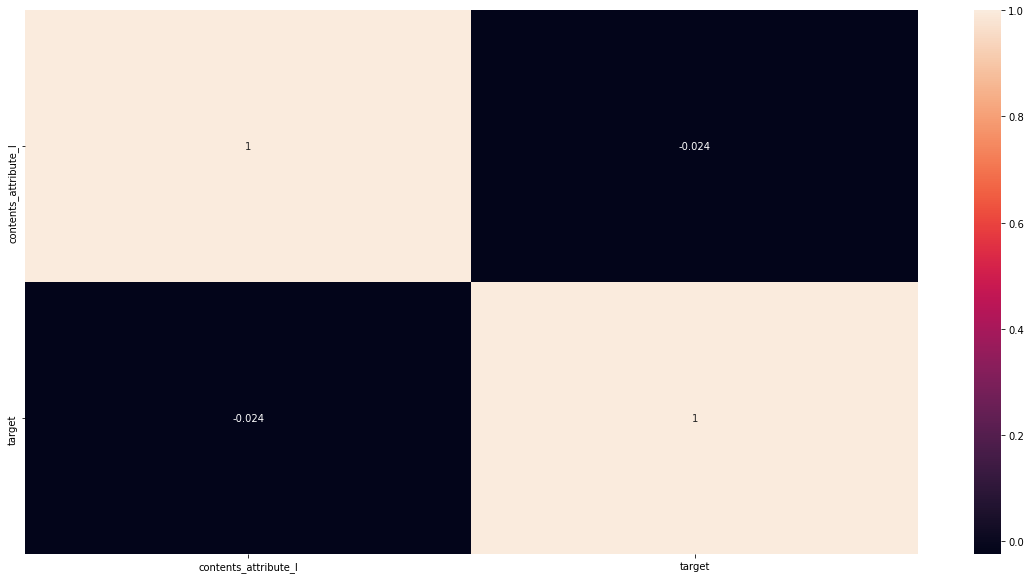

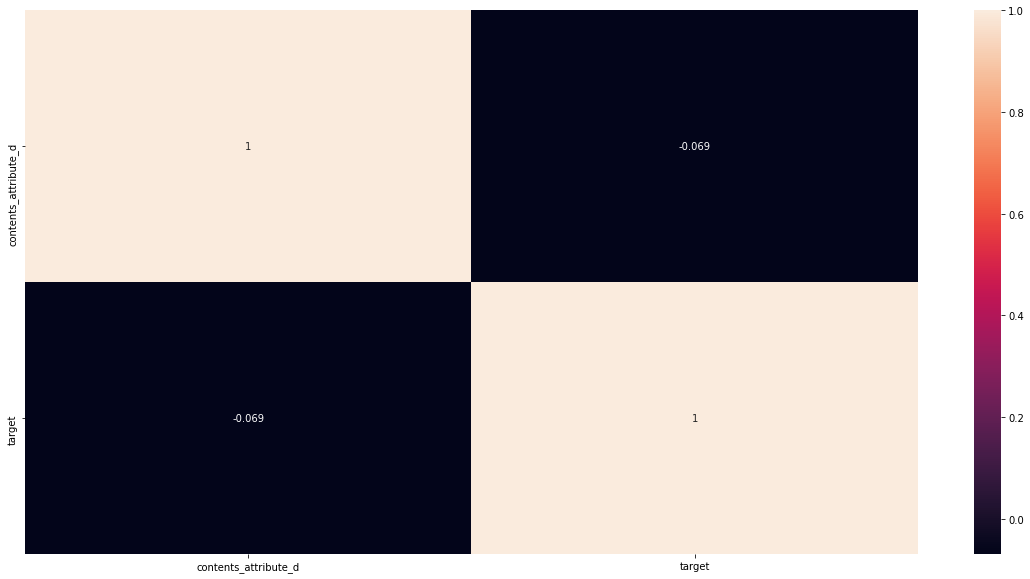

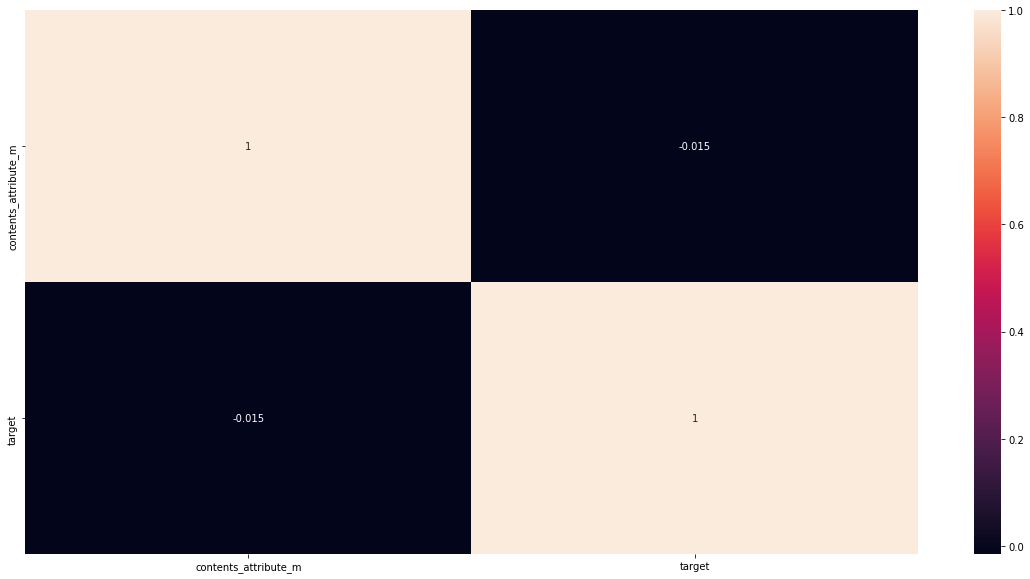

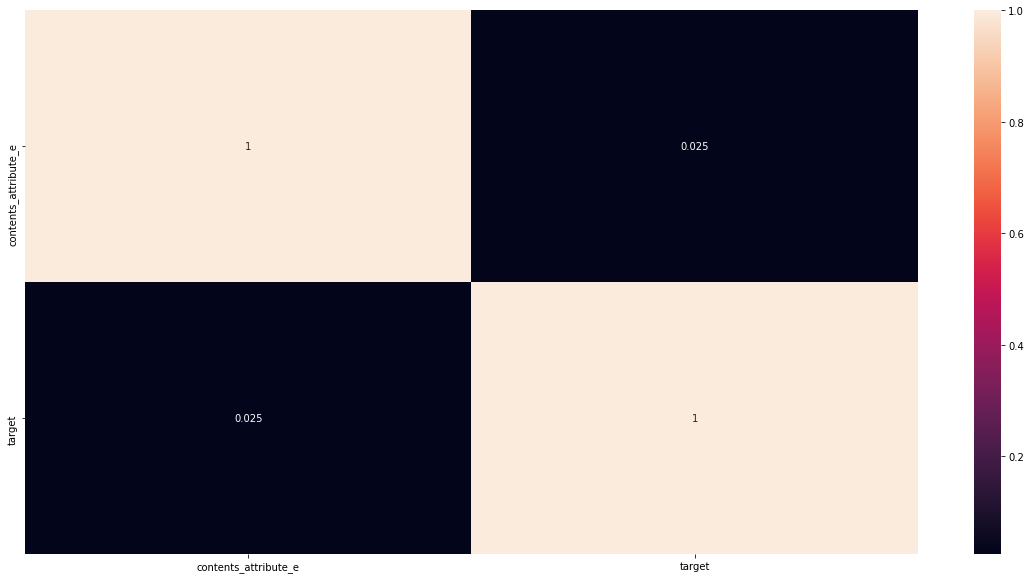

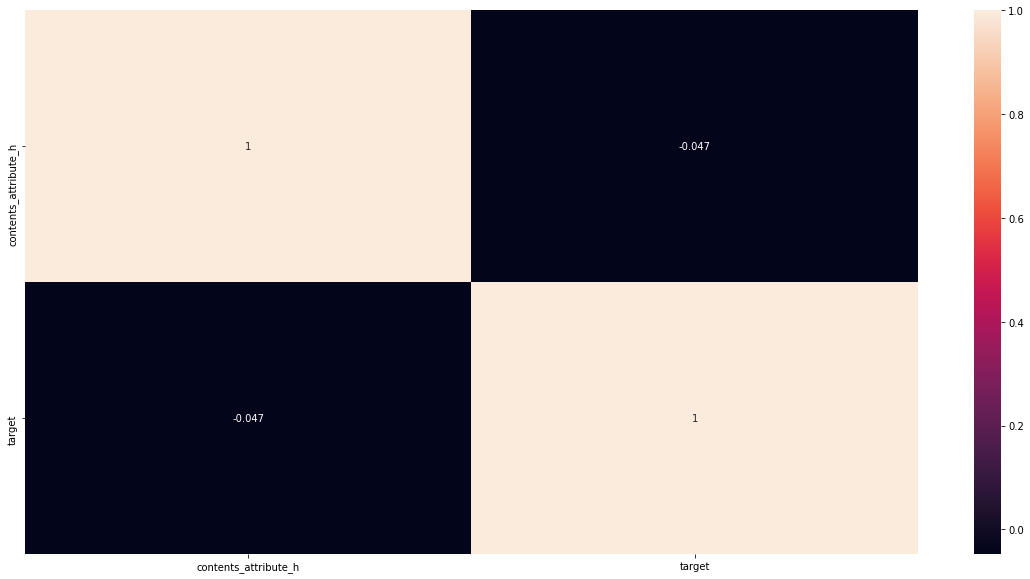

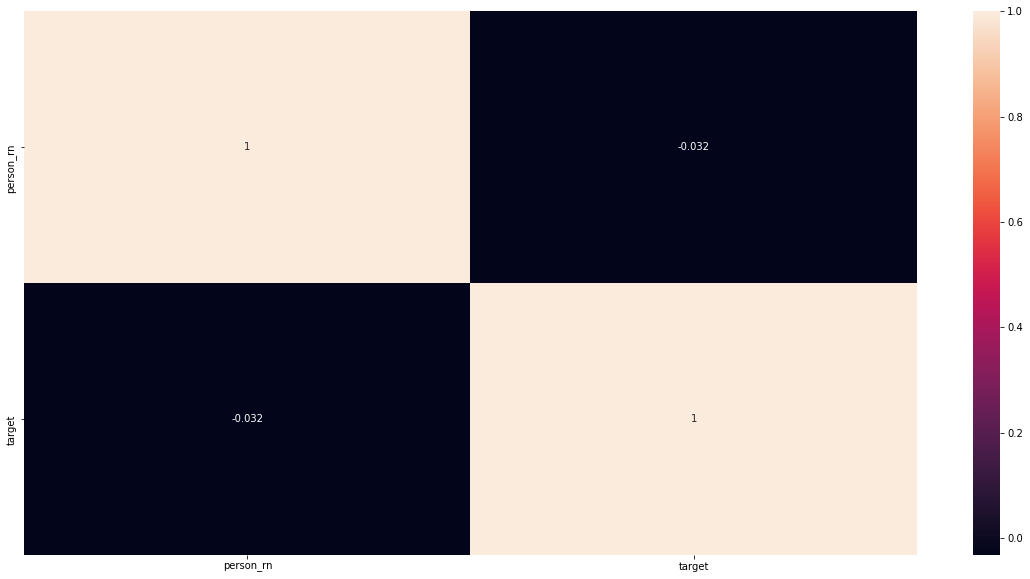

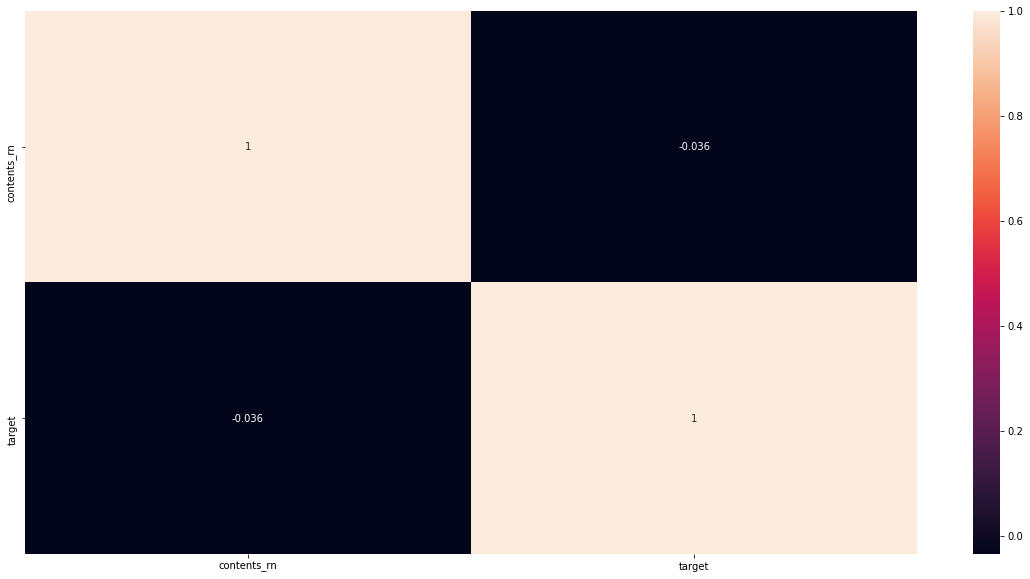

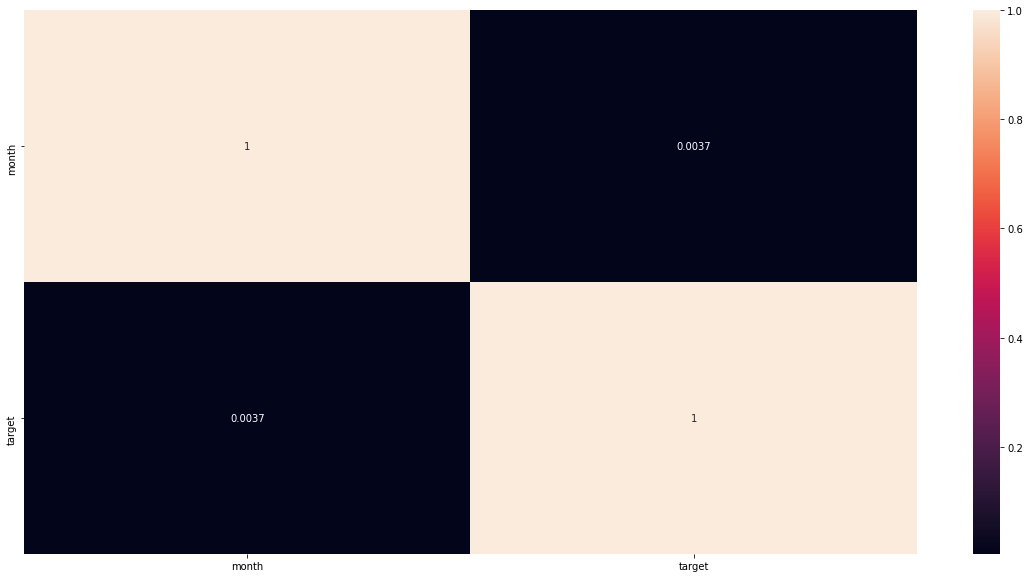

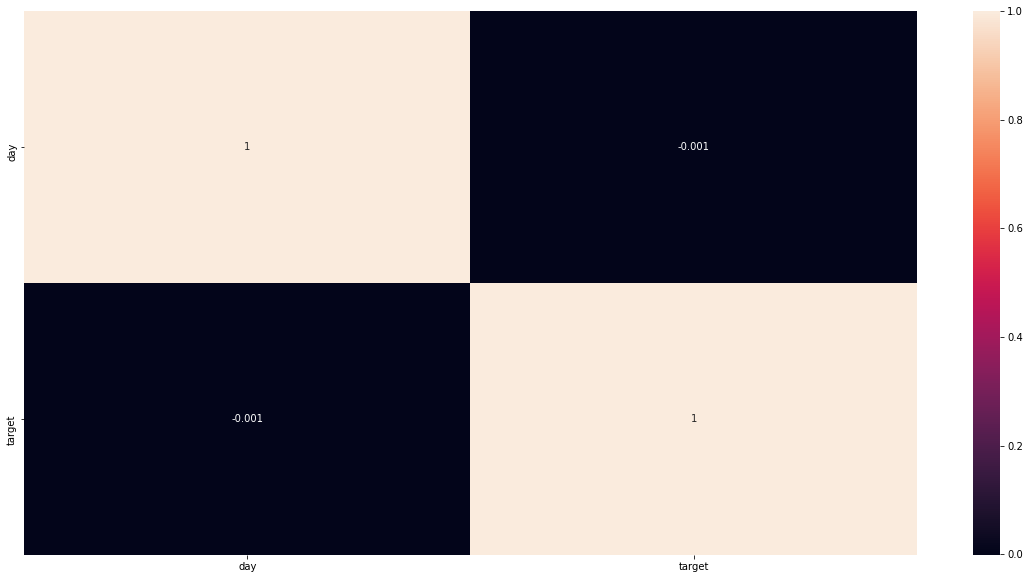

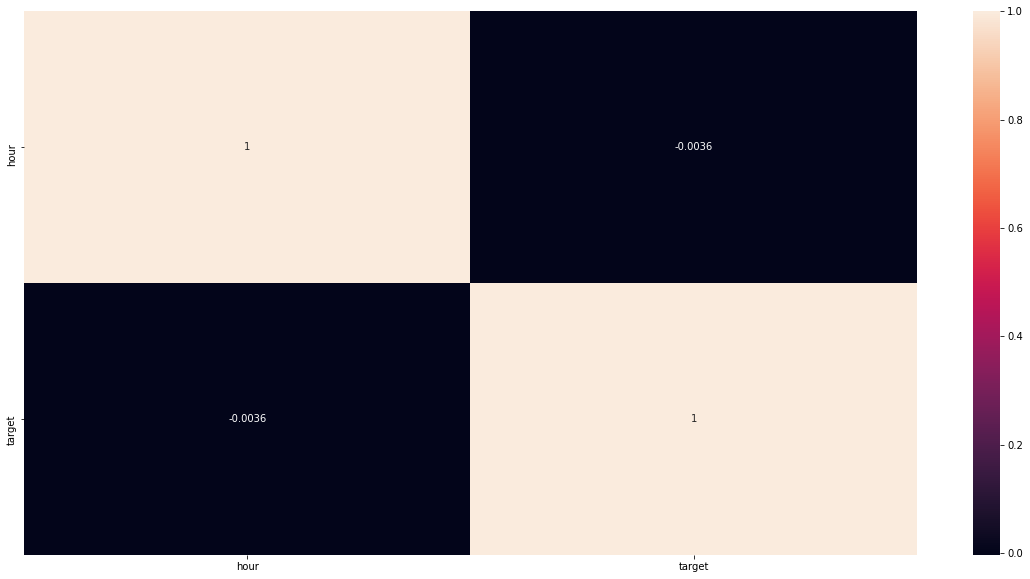

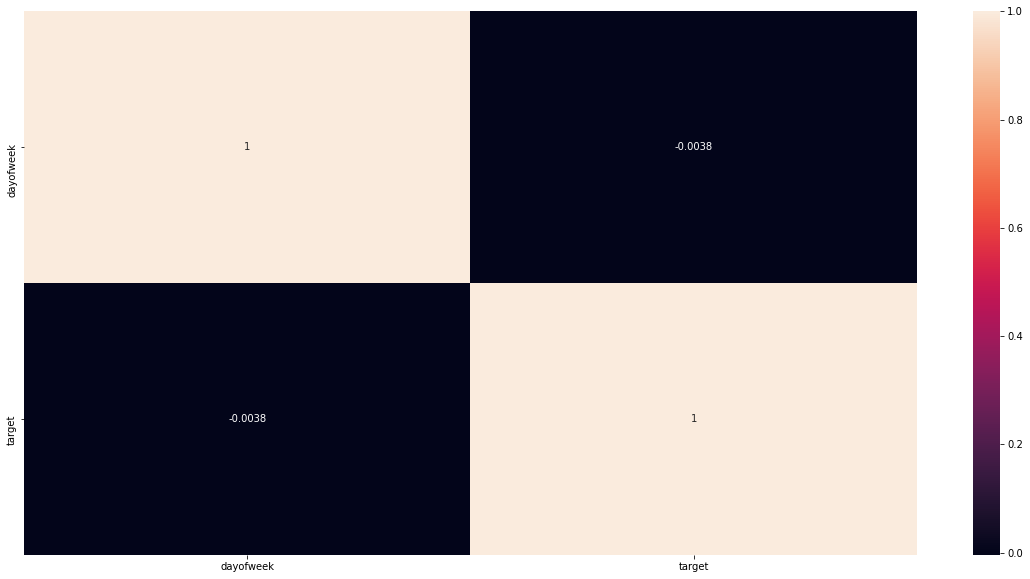

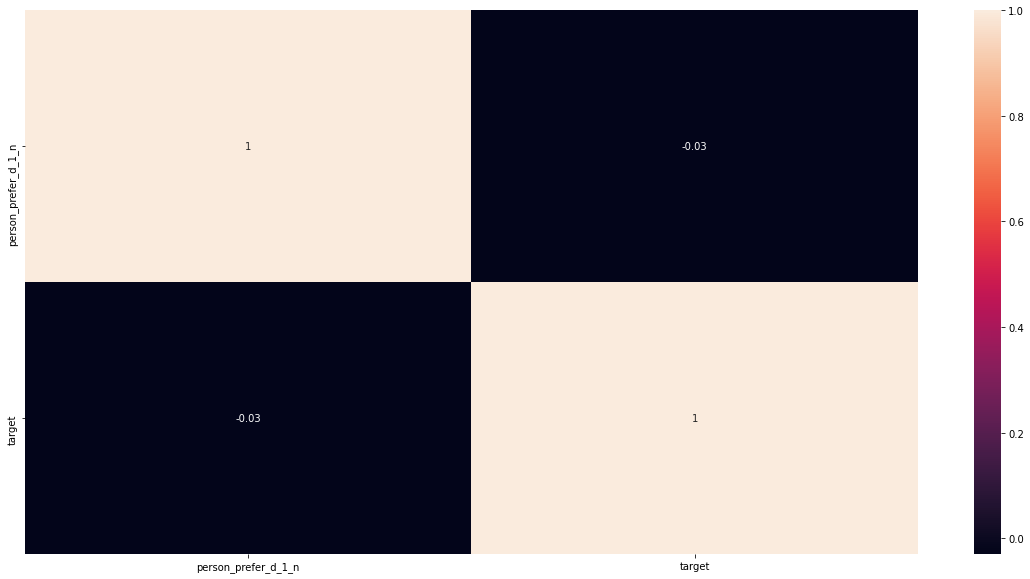

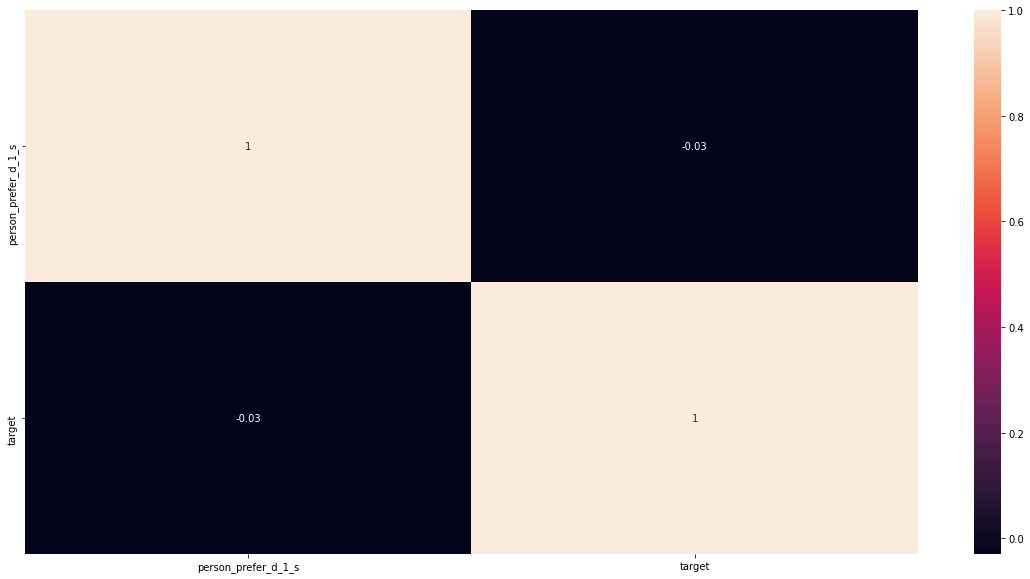

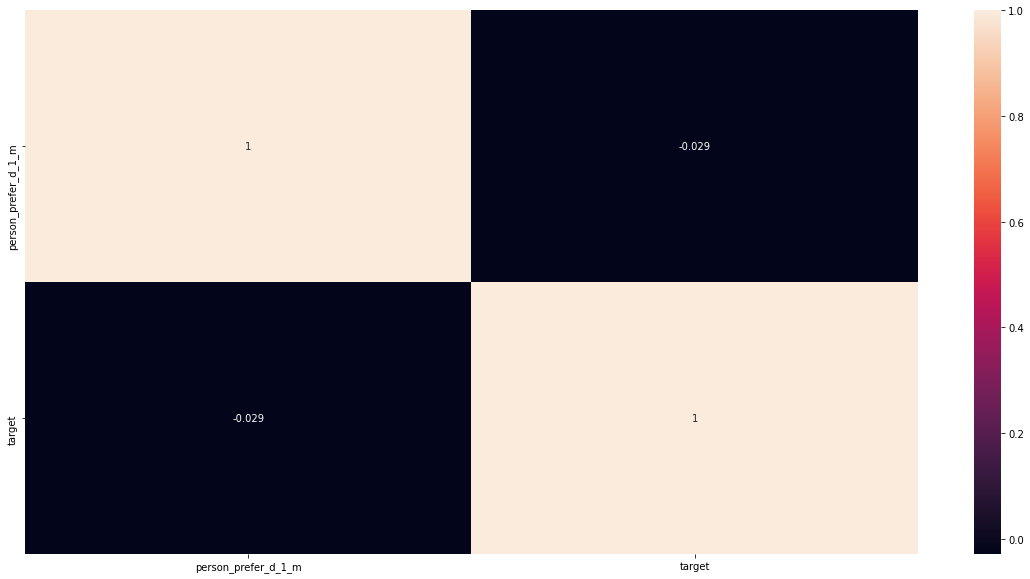

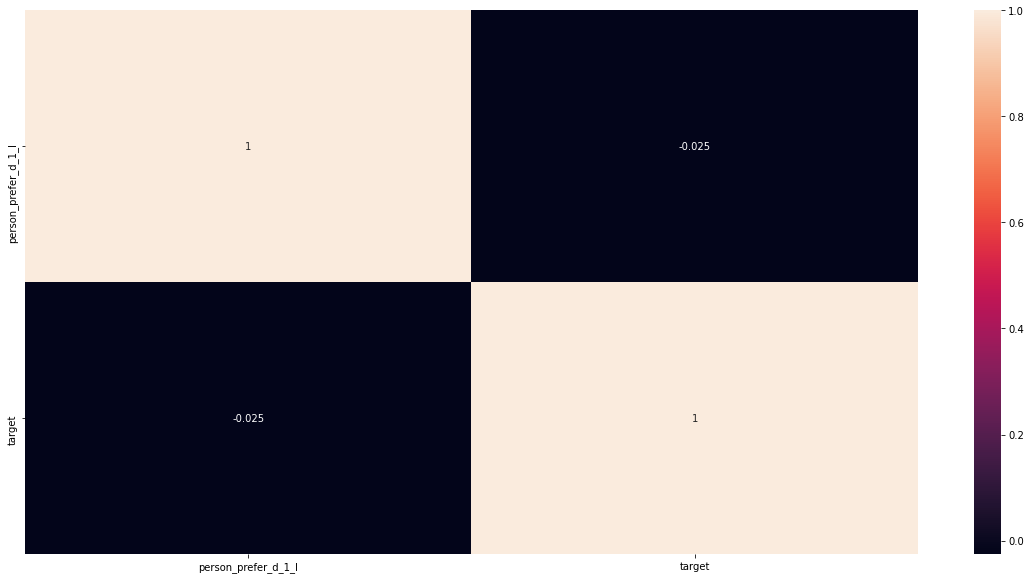

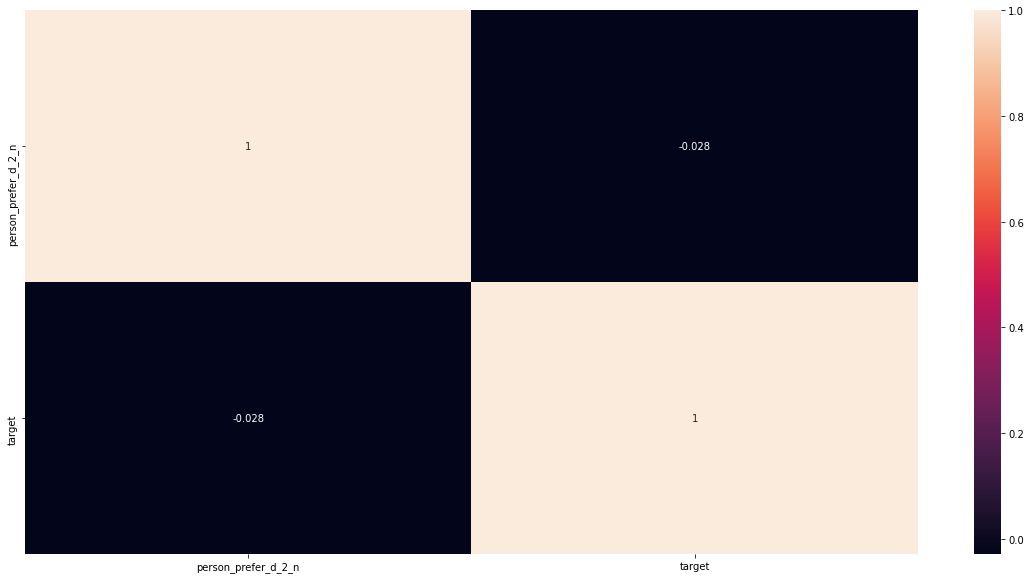

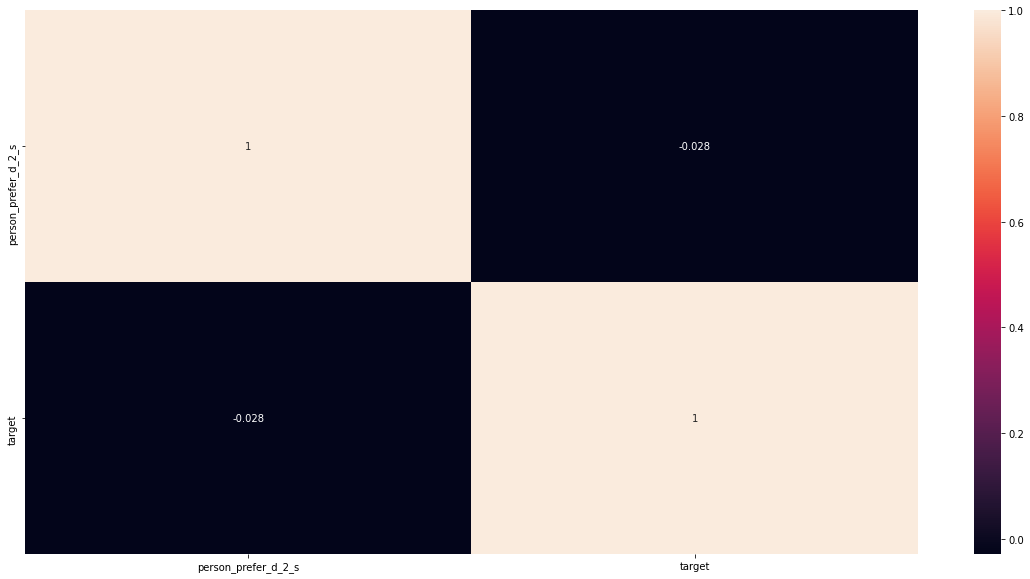

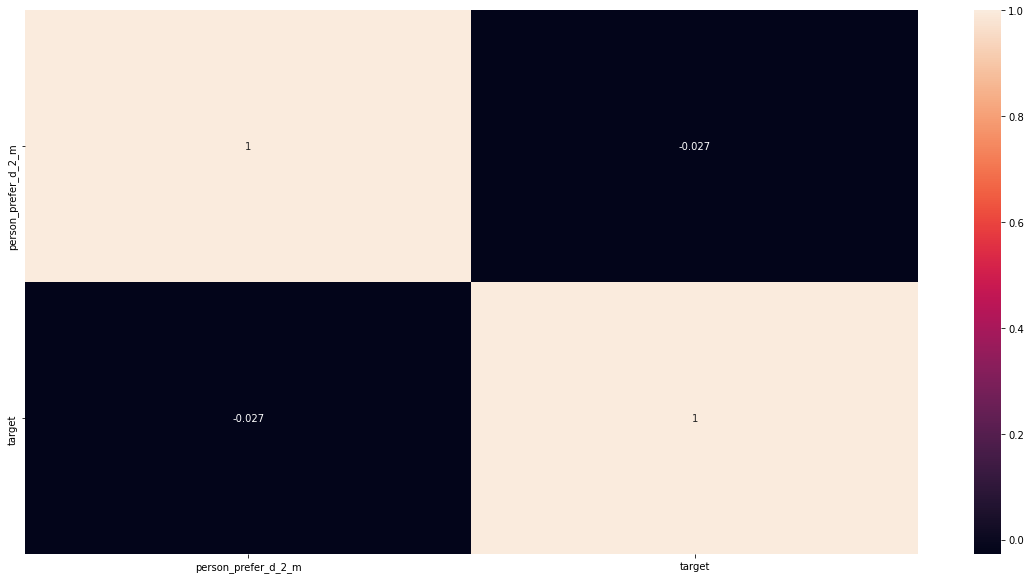

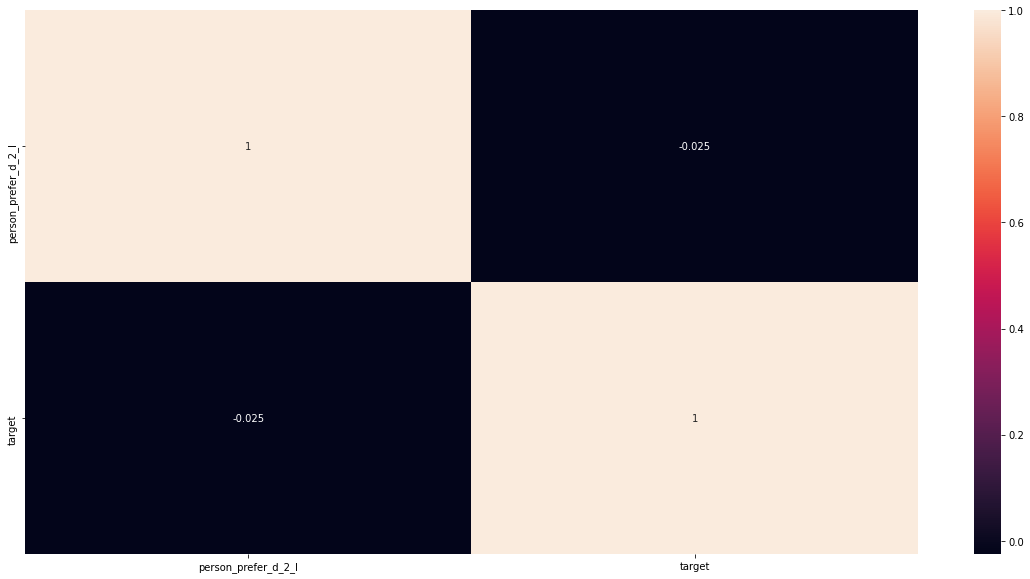

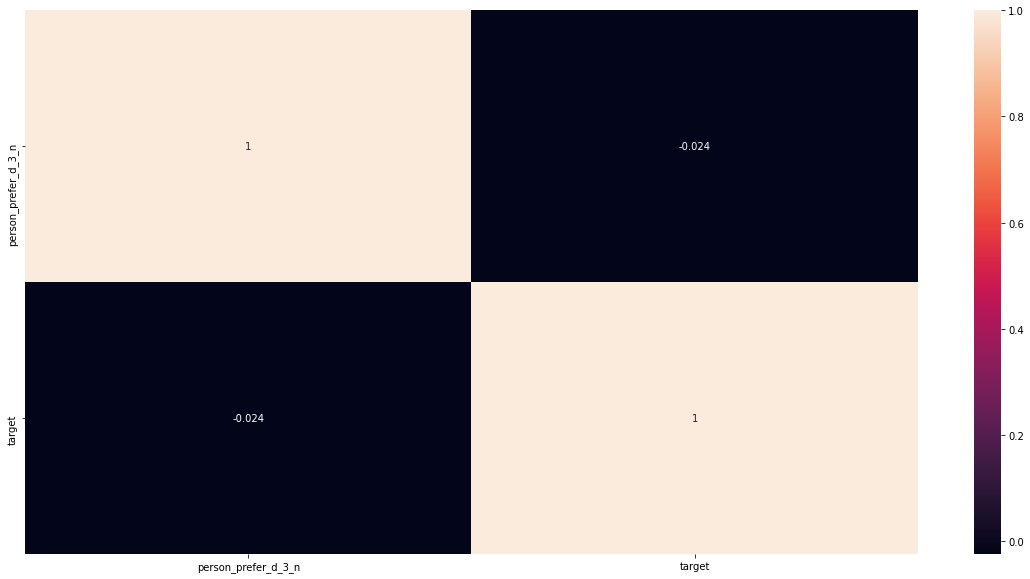

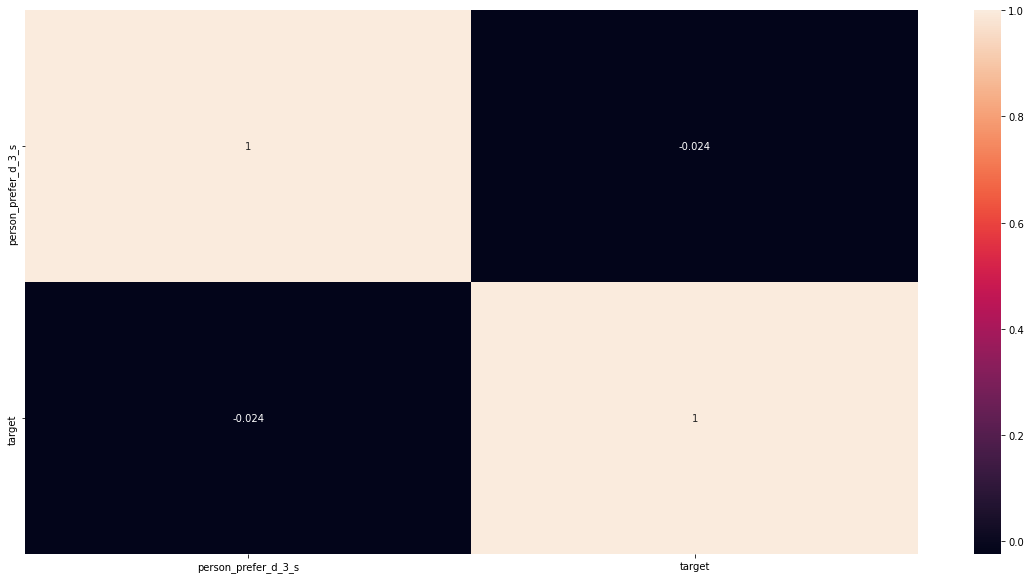

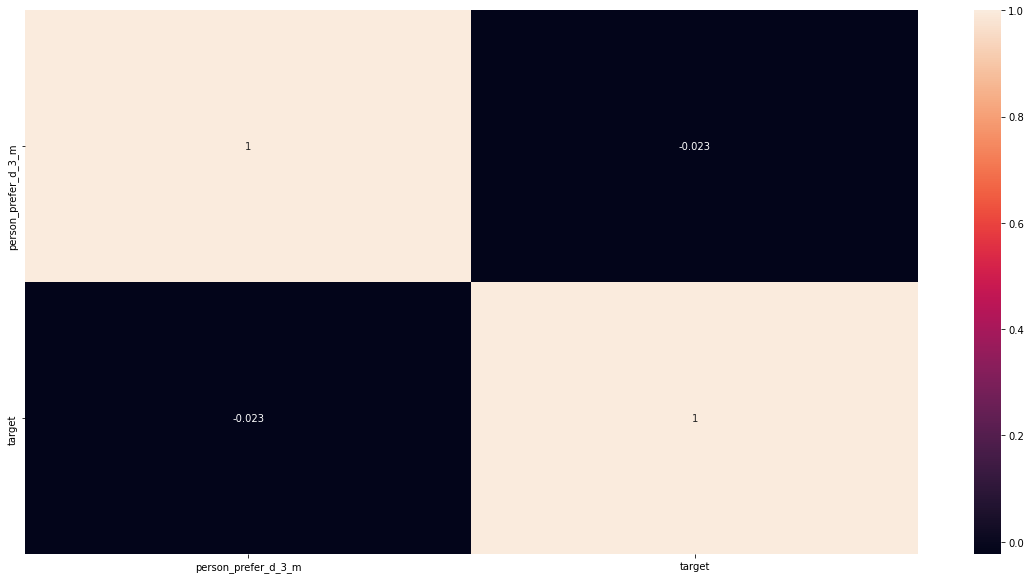

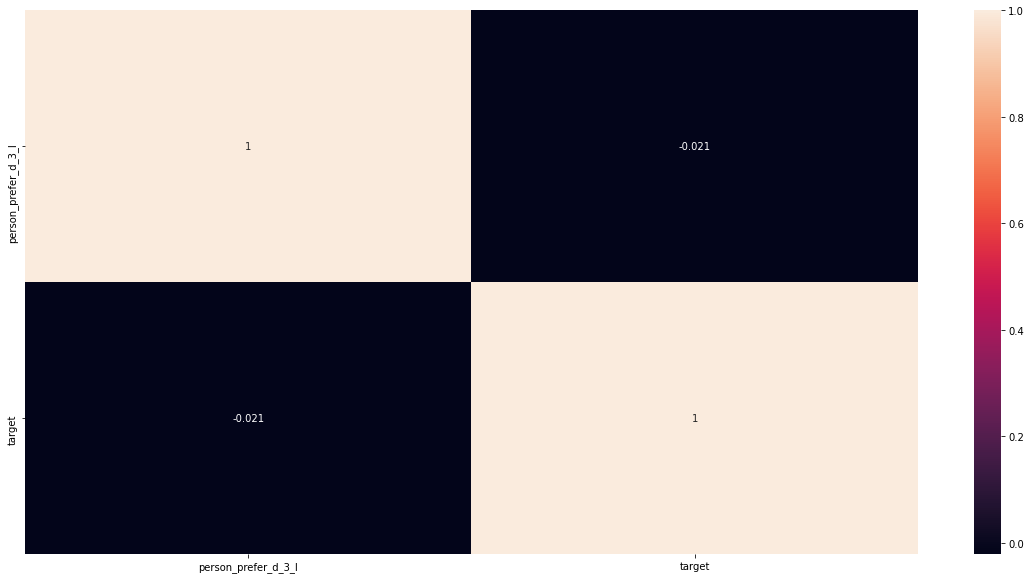

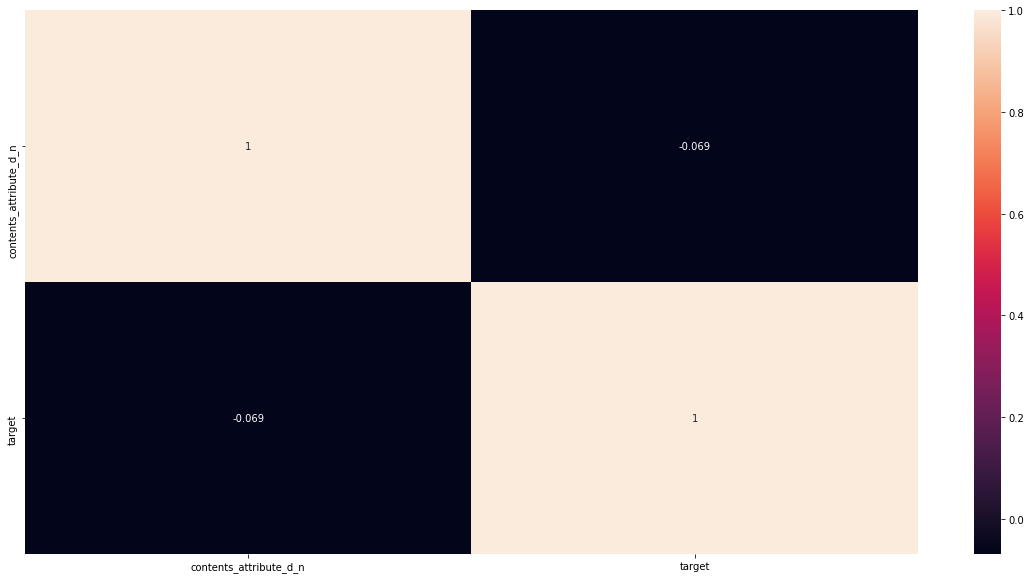

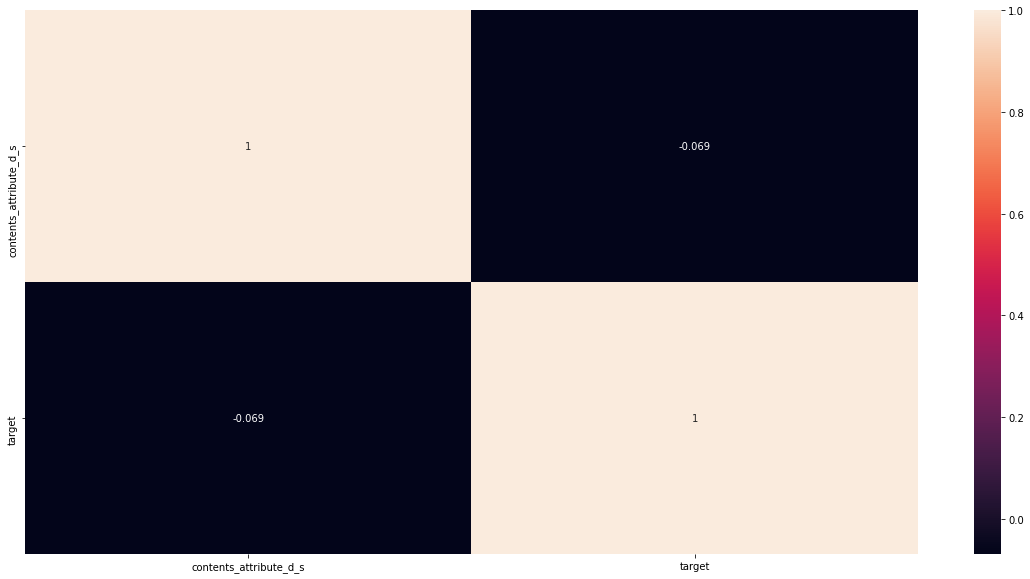

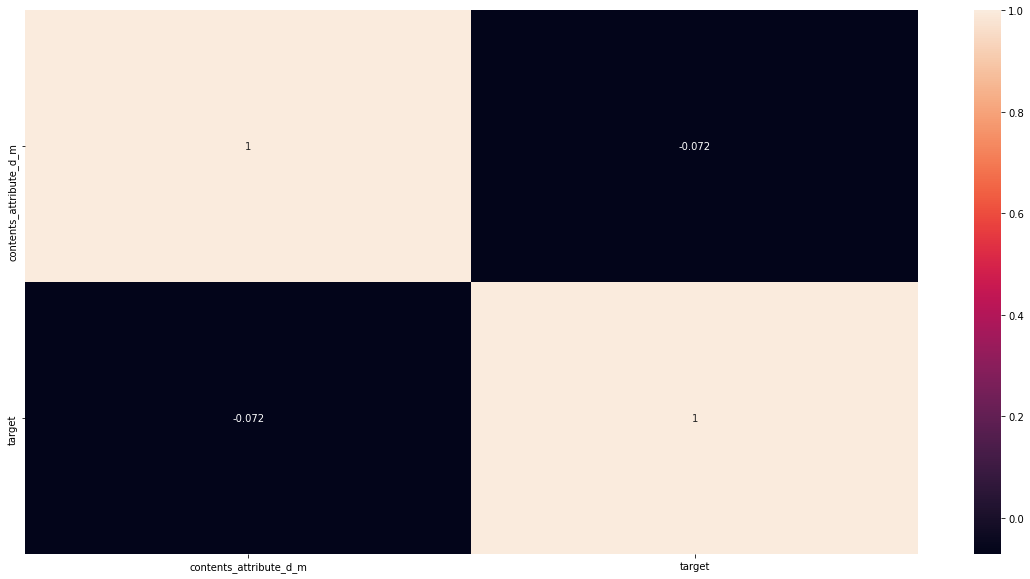

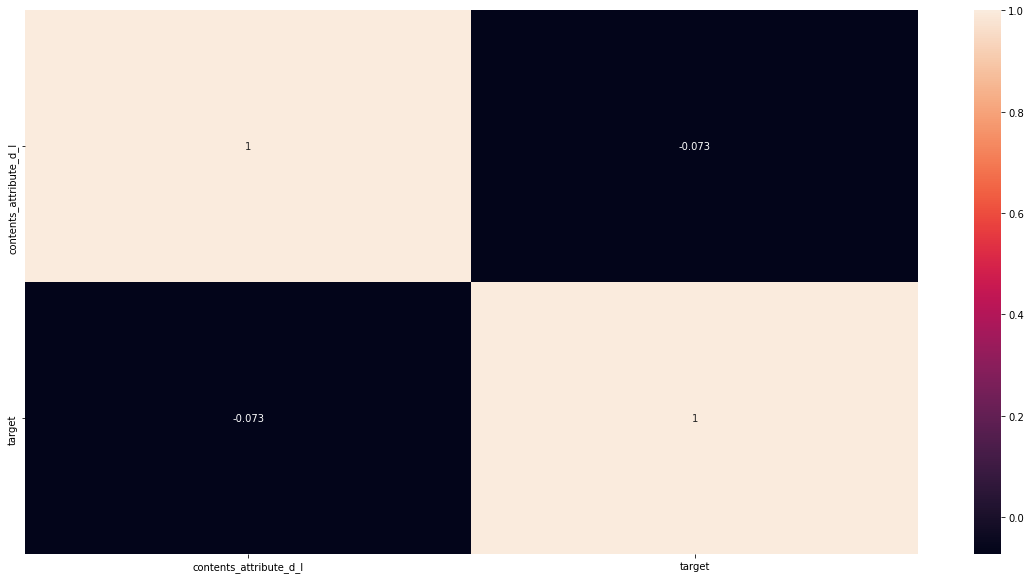

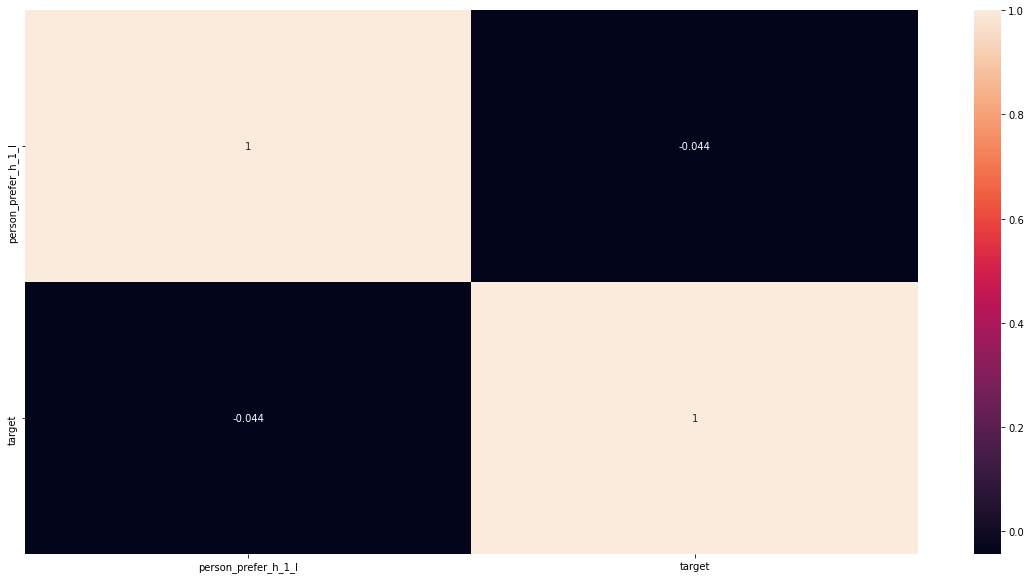

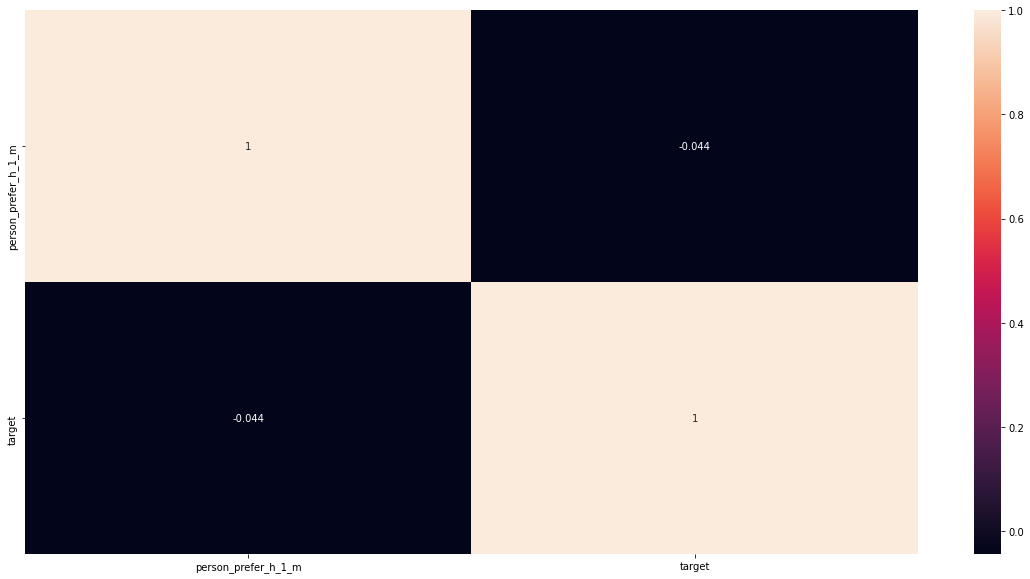

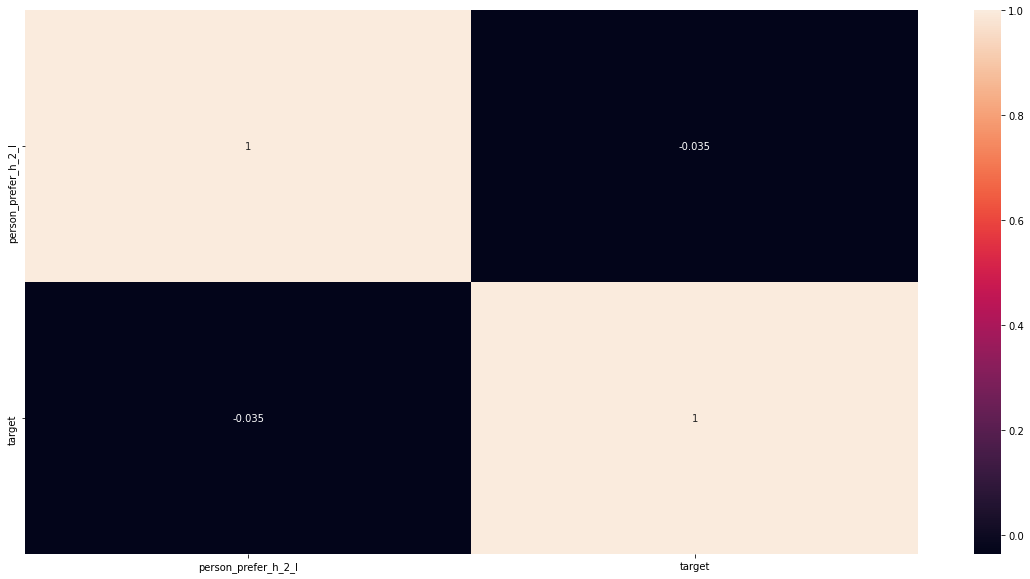

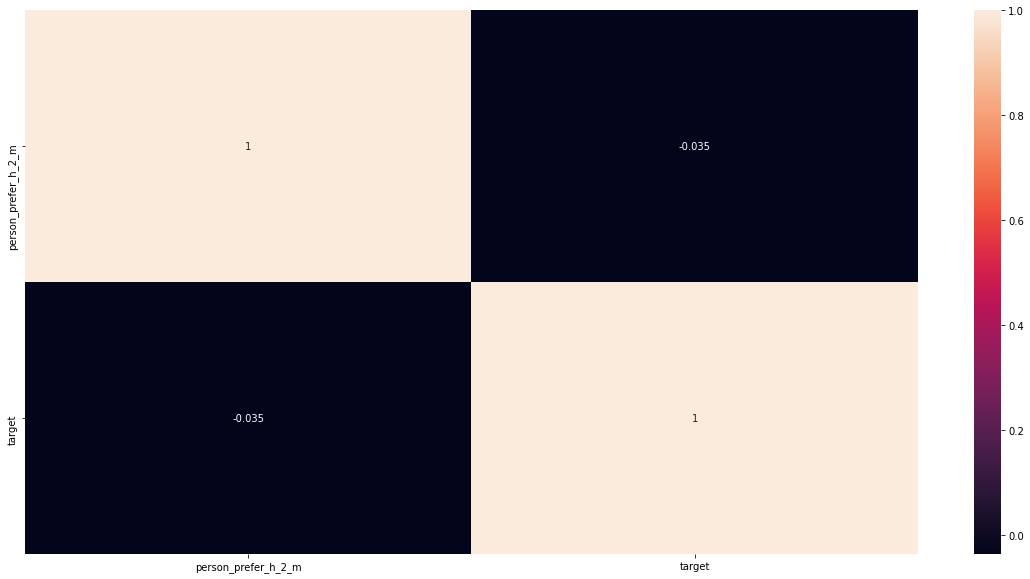

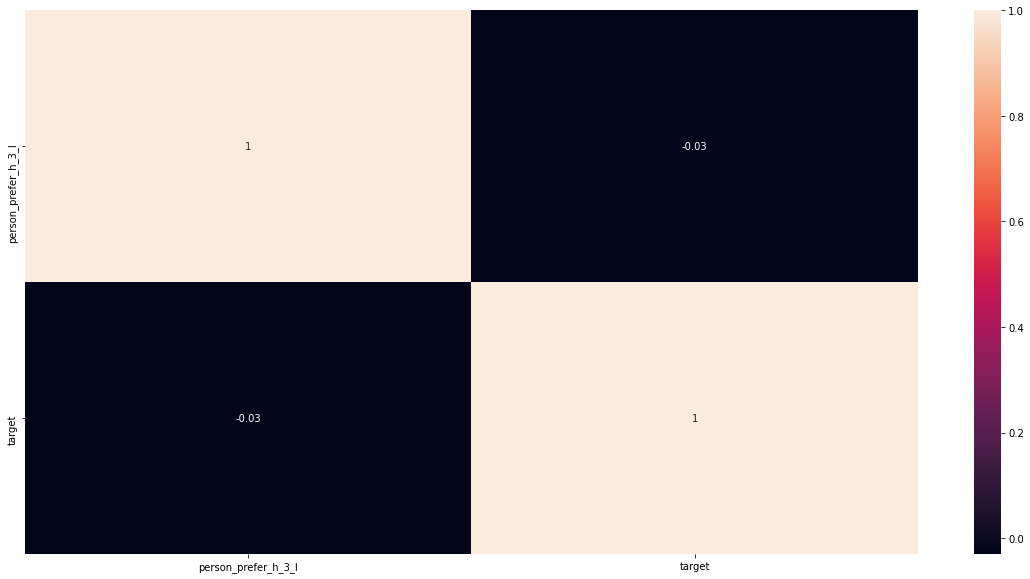

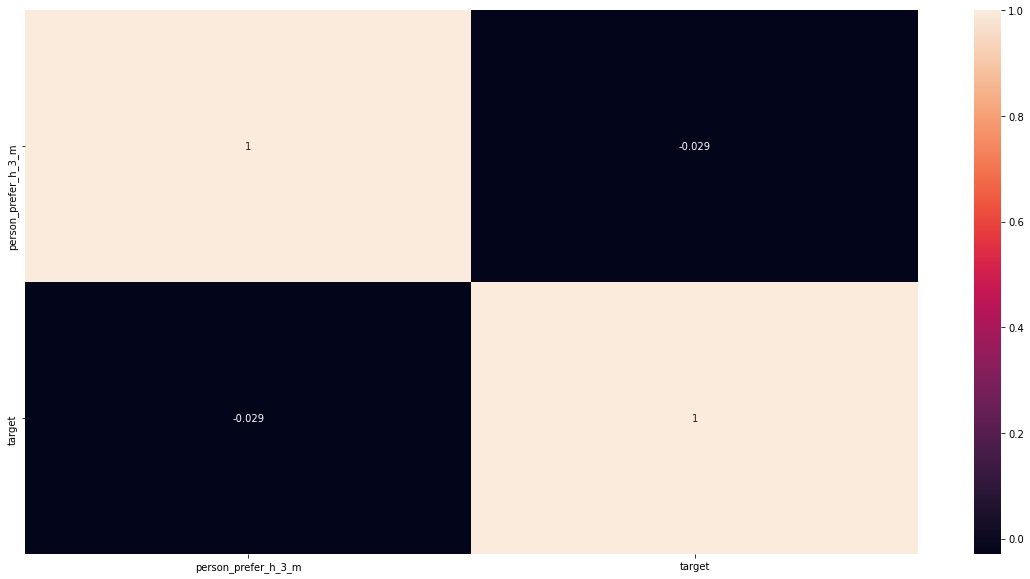

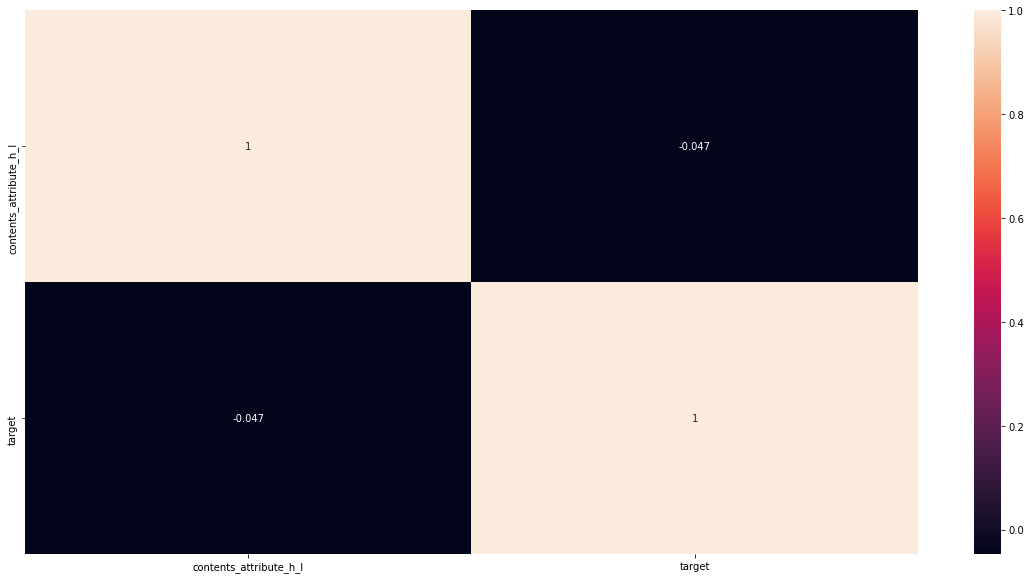

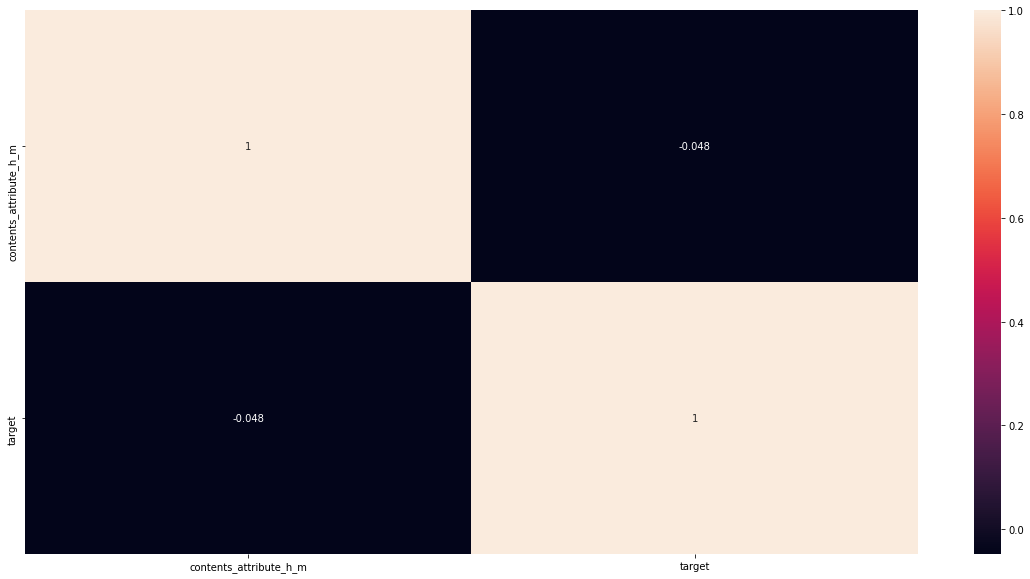

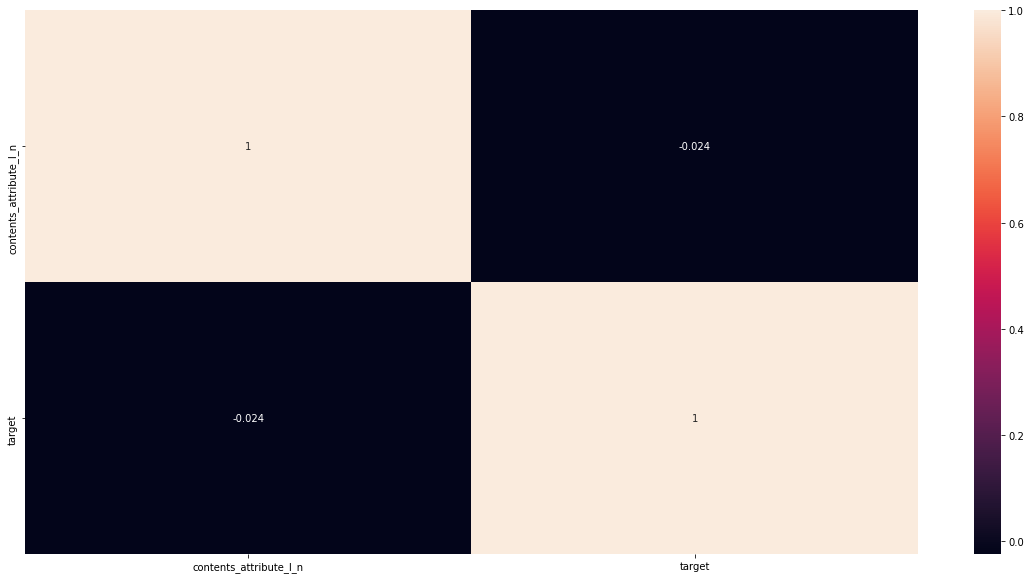

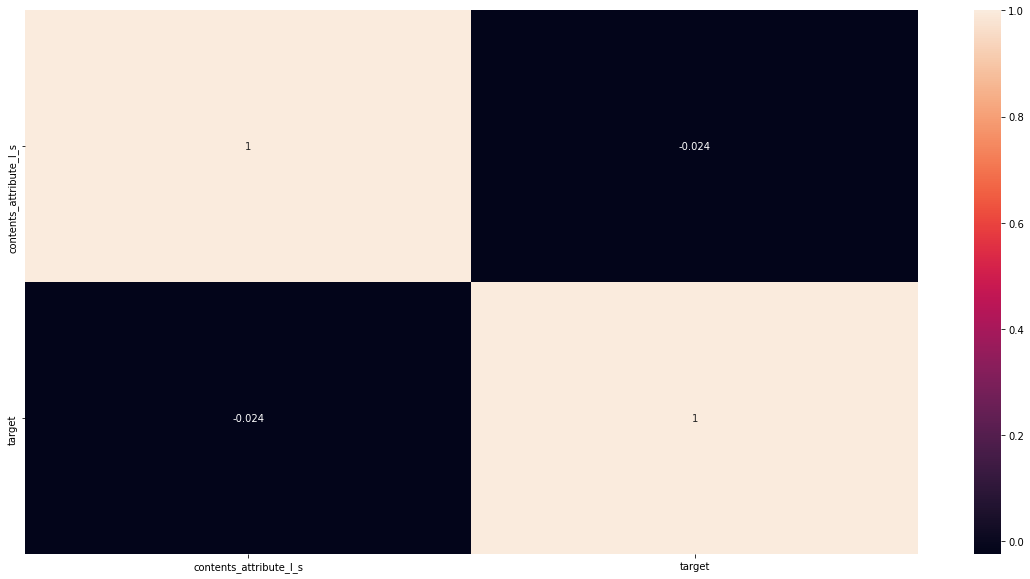

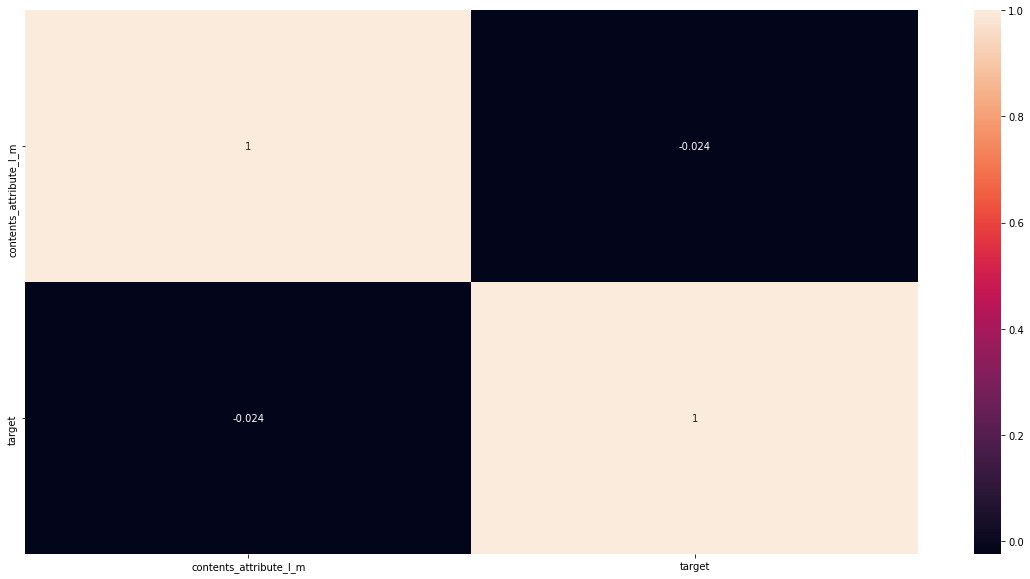

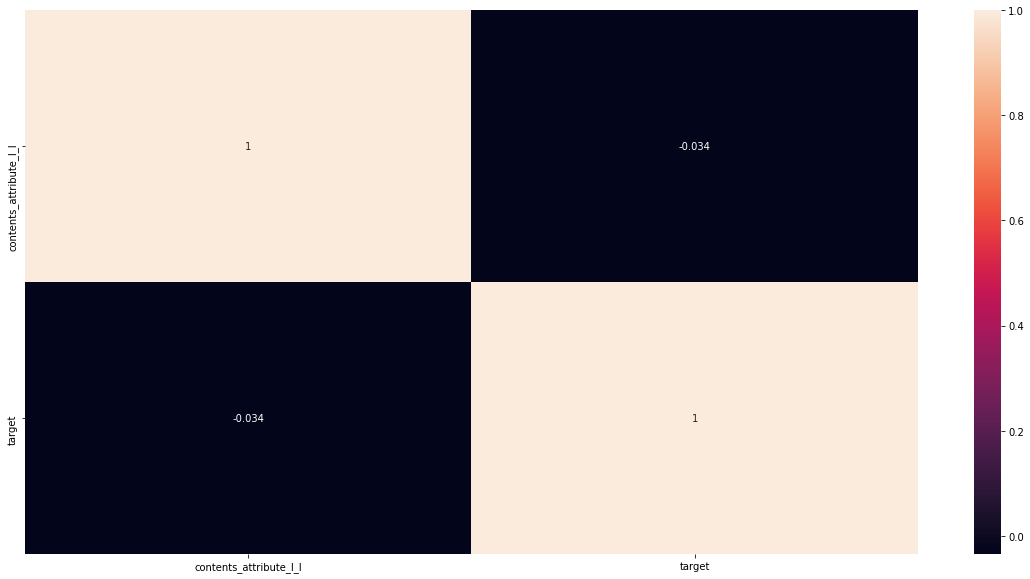

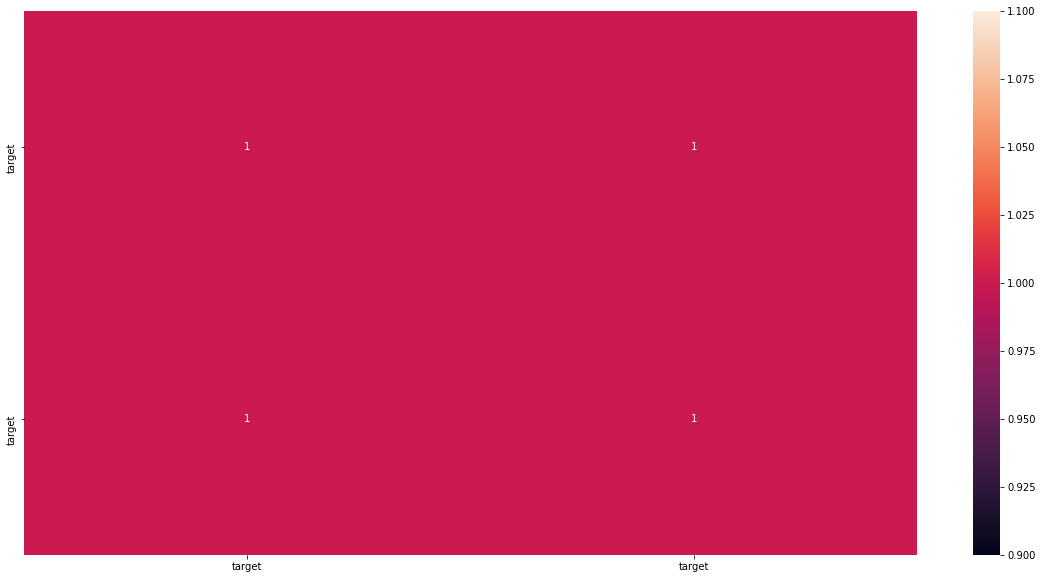

In [74]:
def show_heatmap(df,label):
    df_withlabel = pd.concat([df,label],axis=1)
    for col in df_withlabel.columns:
        plt.figure(figsize = (20,10))
        sns.heatmap(df_withlabel[[col,'target']].corr(),
                    annot=True,
                    annot_kws={"size": 10})
        plt.show()
        
show_heatmap(train_df,label)

In [ ]:
def one_hot_encoding(df_list:list,col_list:list):
    for df in df_list:
        df = pd.get_dummies(df, columns=col_list)
    return df

col_list = train_df.columns.tolist()

for col in ['person_attribute_a_1','person_attribute_b','person_prefer_e','contents_attribute_e','person_rn','contents_rn','']:
    col_list.remove(col)
    
[train_df,test_df] = one_hot_encoding([train_df,test_df],col_list)

In [ ]:
train_df